# Attempt classification on 5 differe orgs

In [1]:
import torch
from torch import nn

import altair as alt
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import scipy
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report

import time


import models as m
import utils as u
import torch_utils as tu
from torch_utils import DatasetSpec

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

# Load 5org data

In [3]:
train_df = pd.read_csv(f'data/5org_cls_splits/cv0_train.tsv',sep='\t').fillna("")
test_df = pd.read_csv(f'data/5org_cls_splits/cv0_test.tsv',sep='\t').fillna("")

In [6]:
test_df

,locus_tag,gene,product,upstream_region,org,id,set
0,EQU24_RS00005,dnaA,chromosomal replication initiator protein DnaA,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,5G,0,test
1,EQU24_RS00010,dnaN,DNA polymerase III subunit beta,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,5G,0,test
2,EQU24_RS00015,recF,DNA replication/repair protein RecF,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,5G,0,test
3,EQU24_RS00020,gyrB,DNA topoisomerase (ATP-hydrolyzing) subunit B,ATTGTTAGTTCTATGTTTAAAGCTTGCGCAAGTACAATTATTGTCG...,5G,0,test
4,EQU24_RS00035,,hypothetical protein,GTATAAACCATGAAAGTCAGCCTATTTCGAAGATACCGACACCCTA...,5G,0,test
...,...,...,...,...,...,...,...
3845,CAETHG_RS04070,,DUF4317 domain-containing protein,GAATCAAATCATGATCTTTTTTTTCATCTACAGATATGTTAAAAGA...,cauto,4,test
3846,CAETHG_RS04075,,HesB-like protein,ACAACTCTCTTTTTTCCACTTCCATCATCTCAAAATGTTCCAGTTC...,cauto,4,test
3847,CAETHG_RS04080,thiI,tRNA 4-thiouridine(8) synthase ThiI,TTAAAATAAATAGTGATGGAAGTGACTATTCACCTTATGTATTAAG...,cauto,4,test
3848,CAETHG_RS04085,,cysteine desulfurase family protein,ATCTATAATAGTATGTGCTCTTATAAATTTTTTTATCCGATCGCTG...,cauto,4,test


In [7]:
seq_len = len(train_df['upstream_region'].values[0])

In [8]:
sampler = tu.make_weighted_sampler(train_df,'id')

In [9]:
dataset_types = [
    DatasetSpec('ohe'),
]

dls = tu.build_dataloaders_single(
                train_df, 
                test_df, 
                dataset_types, # just OHE for now
                seq_col='upstream_region',
                target_col='id',
                sampler=sampler,
                shuffle=False,
            )
ohe_train_dl,ohe_val_dl = dls['ohe']

In [40]:

# model = m.DNA_2CNN_2FC_Multi(
#             seq_len,
#             5, # num tasks
#             num_filters1=32,
#             num_filters2=32,
#             kernel_size1=10,
#             kernel_size2=6,
#             conv_pool_size1=2,
#             fc_node_num1=50,
#             fc_node_num2=50,
#             dropout1=0.25
#         )

m_args = (seq_len,5)
m_kwargs = {
    "num_filters1":32,
    "num_filters2":32,
    "kernel_size1":10,
    "kernel_size2":6,
    "conv_pool_size1":2,
    "fc_node_num1":50,
    "fc_node_num2":50,
    "dropout1":0.25
}

model2 = m.DNA_2CNN_2FC_Multi(*m_args,**m_kwargs)

In [43]:
model2.state_dict()

OrderedDict([('conv_net.0.weight',
              tensor([[[[-0.0176,  0.0162, -0.0332,  ...,  0.0368, -0.1210,  0.0339],
                        [-0.1550, -0.0234,  0.0065,  ..., -0.0386,  0.1468, -0.0099],
                        [-0.0044, -0.0782,  0.1160,  ...,  0.0885,  0.0746,  0.0800],
                        [ 0.0279, -0.0832,  0.0357,  ...,  0.1097,  0.1086,  0.0622]]],
              
              
                      [[[-0.0334,  0.0345,  0.0567,  ...,  0.1466, -0.0709,  0.0254],
                        [-0.1229, -0.0928, -0.0539,  ..., -0.0047, -0.0333, -0.0213],
                        [-0.1376,  0.1297, -0.1440,  ..., -0.0613,  0.0903,  0.0725],
                        [ 0.1295,  0.0908, -0.1368,  ..., -0.0603, -0.0766, -0.1218]]],
              
              
                      [[[-0.1003, -0.1473, -0.0898,  ..., -0.0290,  0.0561, -0.0469],
                        [ 0.0008,  0.0004, -0.0549,  ...,  0.0578, -0.1256, -0.1412],
                        [-0.0150, -0.0309

In [44]:
model.state_dict()

OrderedDict([('conv_net.0.weight',
              tensor([[[[-0.1550,  0.2060,  0.1210,  ..., -0.0736, -0.0446,  0.1181],
                        [-0.0669,  0.0374, -0.0008,  ..., -0.1317, -0.2129, -0.1516],
                        [-0.0185, -0.0320,  0.0919,  ..., -0.0582,  0.0140,  0.0901],
                        [ 0.1346,  0.0224, -0.0276,  ..., -0.1370, -0.0236, -0.0842]]],
              
              
                      [[[ 0.1137, -0.0380,  0.0278,  ...,  0.1127, -0.0174,  0.0797],
                        [-0.1156, -0.0880,  0.0670,  ..., -0.1147, -0.1334, -0.1769],
                        [ 0.0633,  0.0851,  0.0778,  ...,  0.1419,  0.0545, -0.0866],
                        [ 0.0353, -0.1375,  0.1044,  ...,  0.0185, -0.1003, -0.1139]]],
              
              
                      [[[-0.0691,  0.1230, -0.0074,  ...,  0.0646, -0.0643, -0.0096],
                        [-0.0539, -0.2222,  0.0864,  ..., -0.3340,  0.0434,  0.0973],
                        [-0.1680, -0.0082

In [11]:
def collect_model_stats(model_name,seq_len,
                        train_dl,val_dl,
                        lr=0.001,ep=1000,pat=100,
                        opt=None,model=None,load_best=True,chkpt_path='checkpoint.pt'):
    '''
    Execute run of a model and return stats and objects related
    to its results
    '''
    # default model if none specified
    if not model:
        model = m.DNA_2CNN_2FC_Multi(
            seq_len,
            3, # num tasks
        )
    model.to(DEVICE)

    # currently hardcoded for classification
    #loss_func = torch.nn.MSELoss() 
    loss_func = torch.nn.CrossEntropyLoss()
    
    if opt:
        opt = opt(model.parameters(), lr=lr)

    # collect run time
    start_time = time.time()
    
    train_losses, \
    val_losses, \
    epoch_stop, \
    best_val_score = tu.run_model(
        train_dl,
        val_dl, 
        model, 
        loss_func, 
        DEVICE,
        lr=lr, 
        epochs=ep, 
        opt=opt,
        patience=pat,
        load_best=load_best,
        chkpt_path=chkpt_path
    )
    total_time = time.time() - start_time

    # to plot loss
    data_label = [((train_losses,val_losses),model_name,epoch_stop,best_val_score)]
    tu.quick_loss_plot(data_label)
    
    return {
        'model_name':model_name,
        'model':model,
        'opt':opt,
        'train_losses':train_losses,
        'val_losses':val_losses,
        'epoch_stop':epoch_stop,
        'best_val_score':best_val_score,
        'data_label':data_label,
        'total_time':total_time
    }

E:280 | train loss:0.112 | val loss: 0.474:   6%|▌         | 281/5000 [03:03<50:47,  1.55it/s]

EarlyStopping counter: 125 out of 500


E:405 | train loss:0.064 | val loss: 0.554:   8%|▊         | 406/5000 [04:24<49:37,  1.54it/s]

EarlyStopping counter: 250 out of 500


E:530 | train loss:0.041 | val loss: 0.614:  11%|█         | 531/5000 [05:44<48:06,  1.55it/s]

EarlyStopping counter: 375 out of 500


E:655 | train loss:0.031 | val loss: 0.688:  13%|█▎        | 655/5000 [07:05<47:04,  1.54it/s]

EarlyStopping counter: 500 out of 500
Early stopping


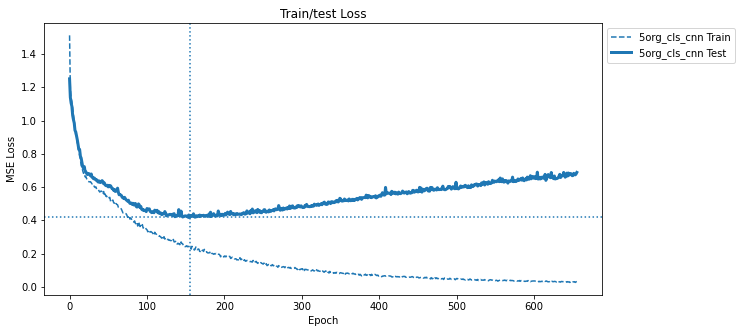

In [12]:
cnn1_name = "5org_cls_cnn"

t_res = collect_model_stats(
    cnn1_name,
    seq_len,
    ohe_train_dl,
    ohe_val_dl,
    lr=0.0001,
    ep=5000,
    pat=500,
    opt=torch.optim.Adam,
    model=model,
)

In [13]:
def get_confusion_stats(model,model_name,seq_list,save_file=False,title=None):#seqs,labels,seq_name):
    '''Get class predictions and plot confusion matrix'''

    def plot_confusion_raw_norm(mats):
        f, axes = plt.subplots(len(seq_list), 2, figsize=(9.8, 4.2*len(seq_list)))#, sharey='row')
        #axes = list(axes)
        axes_list = [item for sublist in axes for item in sublist]

        for i,(mat,subtitle) in enumerate(mats):
            disp = ConfusionMatrixDisplay(confusion_matrix=mat)
            disp.plot(ax=axes_list.pop(0))
            #disp.plot(ax=axes.pop(0))
            disp.ax_.set_title(f"{subtitle}")
            disp.im_.colorbar.remove()

        title_str=title if title else model_name
        f.suptitle(f"{title_str}",fontsize=20)
        plt.tight_layout()
        if save_file:
            plt.savefig(save_file)

    model.eval()
    print(f"Running {model_name}")
    
    mats = [] # conf matrices
    res_data = [] # classification results

    for seqs, labels, split_name in seq_list:
        ohe_seqs = torch.stack([torch.tensor(u.one_hot_encode(x)) for x in seqs]).to(DEVICE)
        preds = [x.topk(1).indices.item() for x in model(ohe_seqs.float())]#.tolist()        
        
        cls_rep = classification_report(labels, preds,output_dict=True)
        pr = cls_rep['macro avg']['precision']
        re = cls_rep['macro avg']['recall']
        f1 = cls_rep['macro avg']['f1-score']
        sp = cls_rep['macro avg']['support']
        res_data.append([model_name,split_name,pr,re,f1,sp])
        
        c = confusion_matrix(labels, preds)
        mats.append((c,f"raw counts ({split_name})"))
        # get the normalized confusino matrix
        cp = np.zeros(c.shape)
        for i,row in enumerate(c):
            rowsum = sum(row)
            for j,item in enumerate(row):
                val = item/rowsum
                cp[i][j] = val

        mats.append((cp,f"normed counts ({split_name})"))

    plot_confusion_raw_norm(mats)
    
    res_df = pd.DataFrame(res_data,columns=['model_name','split','mac_precision','mac_recall','mac_f1','support'])
    
    return res_df

Running 5org_cls_cnn


,model_name,split,mac_precision,mac_recall,mac_f1,support
0,5org_cls_cnn,train,0.953473,0.954590,0.953961,15399
1,5org_cls_cnn,test,0.858691,0.857774,0.858161,3850


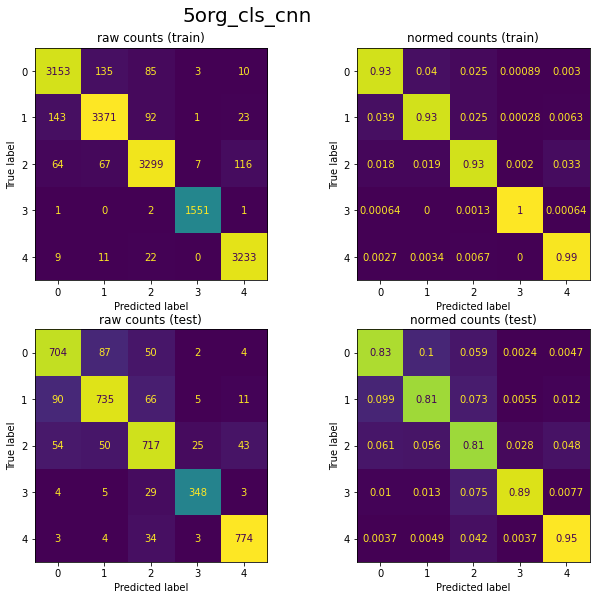

In [14]:
# confusion matrix plotting
seq_list = [
    (train_df["upstream_region"].values,train_df["id"],"train"),
    (test_df["upstream_region"].values,test_df["id"],"test")
]
p_res_df = get_confusion_stats(
    t_res['model'],
    t_res['model_name'],
    seq_list,
    title=f"{t_res['model_name']}"
)

p_res_df

Running 5org_cls_cnn


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,model_name,split,mac_precision,mac_recall,mac_f1,support
0,5org_cls_cnn,train,0.020196,0.2,0.036688,15399
1,5org_cls_cnn,test,0.020208,0.2,0.036707,3850


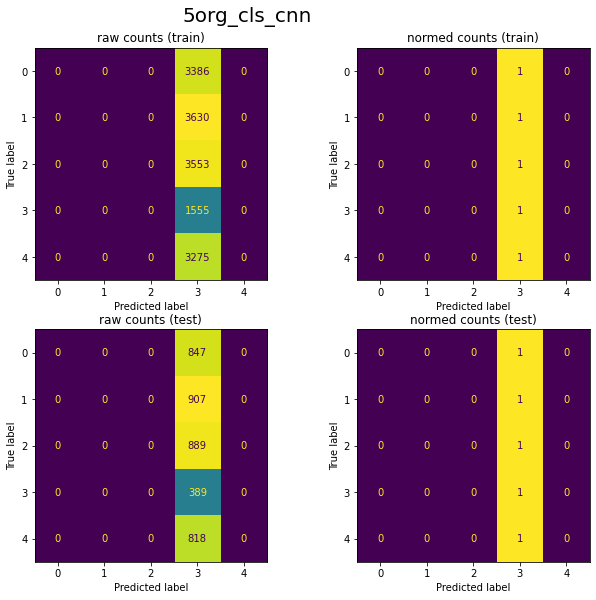

In [48]:
# confusion matrix plotting
seq_list = [
    (train_df["upstream_region"].values,train_df["id"],"train"),
    (test_df["upstream_region"].values,test_df["id"],"test")
]
p_res_df = get_confusion_stats(
    model2.to(DEVICE),
    t_res['model_name'],
    seq_list,
    title=f"{t_res['model_name']}"
)

p_res_df

In [15]:
# quickly test model on other 5G seqs and shuffled sequences

In [16]:
locus_info_filename = 'data/locus2info_20221031.tsv'
locus_info_df = pd.read_csv(locus_info_filename,sep='\t')
locus2info = u.make_info_dict(locus_info_df)

#data_filename = "data/XY_lr_noCu_opFilt.tsv"
#data_filename = "data/XY_logTPM_opFilt_20221031.tsv"
data_filename = "data/XY_lr_noCu_opFilt_20221031.tsv"
XYdf_og = pd.read_csv(data_filename,sep='\t')
XYdf_og['gene'] = XYdf_og['locus_tag'].apply(lambda x: locus2info[x]['gene'])
XYdf_og['product'] = XYdf_og['locus_tag'].apply(lambda x: locus2info[x]['product'])
XYdf_og['type'] = XYdf_og['locus_tag'].apply(lambda x: locus2info[x]['type'])

XYdf_og

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,...,WithLanthanum,NoLanthanum,LanzaTech,aa3_KO,crotonic_acid,CH4_500ppm,CH4_1000ppm,gene,product,type
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,0.333441,-0.087509,-0.248330,-0.654293,0.0,0.252788,0.260753,...,-0.117634,-0.180709,-0.516711,-0.472602,0.058102,0.668619,0.215153,dnaA,chromosomal replication initiator protein DnaA,CDS
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,0.179318,-0.183682,-0.493245,-1.323530,0.0,0.418315,0.611021,...,-0.244793,-0.161434,0.237179,-0.079076,0.132689,-0.462317,-0.490073,dnaN,DNA polymerase III subunit beta,CDS
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,0.364849,0.170159,-0.338861,-0.347147,0.0,0.287824,0.387577,...,-0.249011,-0.066333,-0.987336,-0.990306,0.481623,0.144467,-0.239513,recF,DNA replication/repair protein RecF,CDS
3,4,EQU24_RS00035,GTATAAACCATGAAAGTCAGCCTATTTCGAAGATACCGACACCCTA...,0.193539,0.035923,0.136026,-0.642058,0.0,0.189394,0.345084,...,0.643283,0.566397,-0.952383,-0.465515,0.009531,0.367039,0.695145,NaN,hypothetical protein,CDS
4,9,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,0.173256,0.283822,-0.740565,-1.011908,0.0,0.215938,0.306791,...,0.539188,0.622656,-0.716034,-0.025042,0.070784,-0.367242,-0.319915,NaN,bifunctional diguanylate cyclase/phosphodieste...,CDS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2206,4182,EQU24_RS23145,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,0.620221,0.718300,0.245892,-1.598809,0.0,0.171579,0.501296,...,0.977712,1.564370,0.701928,1.577361,0.777911,0.463434,0.727701,hxlA,3-hexulose-6-phosphate synthase,CDS
2207,4184,EQU24_RS23155,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,0.609995,0.702416,0.231606,-1.614646,0.0,0.154029,0.483579,...,0.952955,1.548383,0.701457,1.573150,0.761210,0.433925,0.705205,hxlA,3-hexulose-6-phosphate synthase,CDS
2208,4186,EQU24_RS23165,TTGAAACCCTAAGGTACATTGAGGCGTTAGCAAAGAGCAAGTTTGA...,0.605448,0.688065,0.233752,-1.594922,0.0,0.171939,0.486032,...,0.899683,1.442487,0.708730,1.520411,0.769644,0.032260,0.305817,hxlA,3-hexulose-6-phosphate synthase,CDS
2209,4187,EQU24_RS23170,AATCTTCATTAGAGTCGAACGAAGTTTCATGTTTTCGGCTTCCTCA...,0.604488,0.196871,-0.261330,0.125607,0.0,-0.014653,0.229101,...,-0.233161,0.107133,0.265191,-0.870372,0.814080,-0.245552,-0.285502,NaN,transposase,CDS


In [17]:
def shuffle_seq(dna):
    to_shuffle = list(dna)
    random.shuffle(to_shuffle)
    return  ''.join(to_shuffle)

In [18]:
fake_df = XYdf_og[['locus_tag','upstream_region']]
fake_df['shuffled_seq'] = fake_df['upstream_region'].apply(lambda x: shuffle_seq(x))
fake_df

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,locus_tag,upstream_region,shuffled_seq
0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,GTCTTCTGAGTGTTATAAGCTGGAGTTCTTCAGTGTTGTGTACCCA...
1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,TTGATGTGTATATTGGACCTAACTACGCAAACCTTTGTCCTTGTAA...
2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,TAGGCAGACTTGGTAAGGTTCGTATTAGATGTCAAAGTAAGAGGTA...
3,EQU24_RS00035,GTATAAACCATGAAAGTCAGCCTATTTCGAAGATACCGACACCCTA...,ACCATGCTAGACCATTCTCTAAAGCACATCTAGAGGTTACTTGTTA...
4,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,ATTTATGAAGATACTACTACGCCAACACGCCTTTTCTGCTCGAATG...
...,...,...,...
2206,EQU24_RS23145,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,CAAAATGTCAATCTGGTGTCTGAAAACGGCGCATCCAAAGATCGCT...
2207,EQU24_RS23155,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,GTCTCCATAGAAACGCCATGGCATGAAATTCAAGTTTCTGTCGACG...
2208,EQU24_RS23165,TTGAAACCCTAAGGTACATTGAGGCGTTAGCAAAGAGCAAGTTTGA...,AGCTTGAAATTGGACTCTAGTCTTCGTCATTTTTGATGACACTTAG...
2209,EQU24_RS23170,AATCTTCATTAGAGTCGAACGAAGTTTCATGTTTTCGGCTTCCTCA...,GTTAGAGGTGAAGTAACAACTTCCGTTGAGCGTGTTGGTTTTAGAA...


Running 5org_cls_cnn


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in long_scalars


,model_name,split,mac_precision,mac_recall,mac_f1,support
0,5org_cls_cnn,5g real,0.2,0.180371,0.189679,2211
1,5org_cls_cnn,shuffles,0.2,0.056083,0.087602,2211


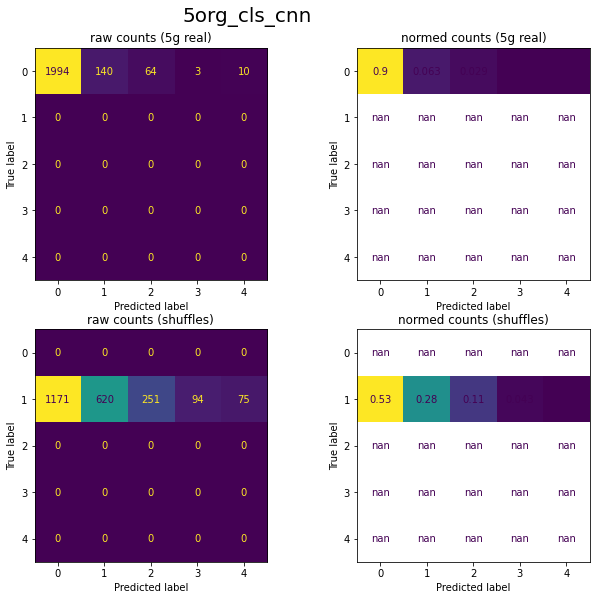

In [19]:
# confusion matrix plotting
fake_seq_list = [
    (fake_df["upstream_region"].values,[0 for x in fake_df['upstream_region'].values],"5g real"),
    (fake_df["shuffled_seq"].values,[1 for x in fake_df['shuffled_seq'].values],"shuffles")
]
fake_res_df = get_confusion_stats(
    t_res['model'],
    t_res['model_name'],
    fake_seq_list,
    title=f"{t_res['model_name']}"
)

fake_res_df

In [20]:
# Shuffle all the seqs

In [21]:
train_df['shuffled_seq'] = train_df['upstream_region'].apply(lambda x: shuffle_seq(x))
test_df['shuffled_seq'] = test_df['upstream_region'].apply(lambda x: shuffle_seq(x))


Running 5org_cls_cnn


,model_name,split,mac_precision,mac_recall,mac_f1,support
0,5org_cls_cnn,train shuff,0.403572,0.392118,0.379712,15399
1,5org_cls_cnn,test shuff,0.390024,0.378667,0.367586,3850


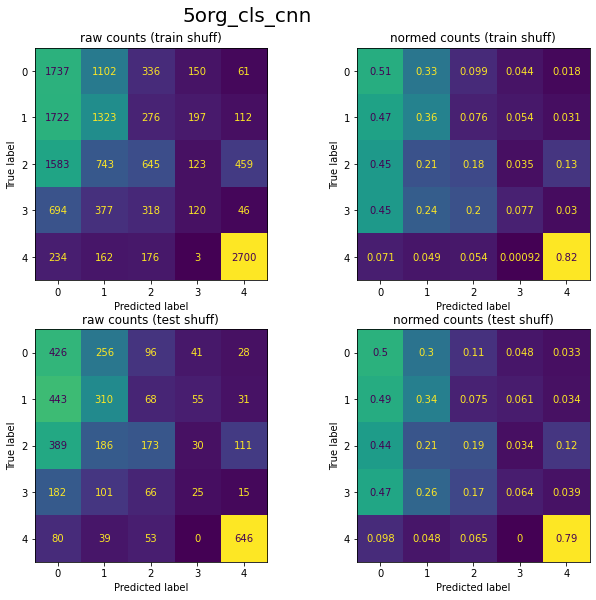

In [22]:
shuff_seq_list = [
    (train_df["shuffled_seq"].values,train_df['id'].values,"train shuff"),
    (test_df["shuffled_seq"].values,test_df['id'].values,"test shuff")
]
shuff_res_df = get_confusion_stats(
    t_res['model'],
    t_res['model_name'],
    shuff_seq_list,
    title=f"{t_res['model_name']}"
)

shuff_res_df

# Look at filters?

In [55]:
def get_conv_layers_from_model(model):
    '''
    Given a trained model, extract its convolutional layers
    '''
    model_children = list(model.children())
    
    # counter to keep count of the conv layers
    model_weights = [] # we will save the conv layer weights in this list
    conv_layers = [] # we will save the actual conv layers in this list
    bias_weights = []
    counter = 0 

    # append all the conv layers and their respective weights to the list
    for i in range(len(model_children)):
        # get model type of Conv1d
        if type(model_children[i]) == nn.Conv2d:
            counter += 1
            model_weights.append(model_children[i].weight)
            conv_layers.append(model_children[i])
            bias_weights.append(model_children[i].bias)

        # also check sequential objects' children for conv1d
        elif type(model_children[i]) == nn.Sequential:
            for child in model_children[i]:
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
                    bias_weights.append(child.bias)

    print(f"Total convolutional layers: {counter}")
    return conv_layers, model_weights, bias_weights

def view_filters(model_weights, num_cols=8):
    # squeeze for conv2d??
    model_weights = model_weights[0].squeeze(1)
    num_filt = model_weights.shape[0]
    filt_width = model_weights[0].shape[1]
    num_rows = int(np.ceil(num_filt/num_cols))
    
    # visualize the first conv layer filters
    plt.figure(figsize=(20, 17))

    for i, filter in enumerate(model_weights):
        ax = plt.subplot(num_rows, num_cols, i+1)
        ax.imshow(filter.cpu().detach(), cmap='gray')
        ax.set_yticks(np.arange(4))
        ax.set_yticklabels(['A', 'C', 'G','T'])
        ax.set_xticks(np.arange(filt_width))
        ax.set_title(f"Filter {i}")

    plt.tight_layout()
    plt.show()
    
def get_conv_output_for_seq(seq, conv_layer):
    '''
    Given an input sequeunce, get the output tensor containing the filter activations
    '''
    #print(f"Running seq {seq}")
    # format seq for input to conv layer (OHE, reshape)
    seq = torch.tensor(u.one_hot_encode(seq)).view(-1,len(seq),4).permute(0,2,1).unsqueeze(0).to(DEVICE)
    # OHE FIX??
    # run through conv layer
    with torch.no_grad(): # don't want as part of gradient graph?
        res = conv_layer(seq.float())
        return res[0]
    

def get_filter_activations(seqs, conv_layer,act_thresh=0):
    '''
    Given a set of input sequences and a trained convolutional layer, 
    determine the subsequences for which each filter in the conv layer 
    activate most strongly. 
    
    1.) Run inputs through conv layer. 
    2.) Loop through filter activations of the resulting tensor, saving the
            position where filter activations were >0. 
    3.) Compile a count matrix for each filter by accumulating subsequences which
            activate the filter
    '''
    # initialize dict of pwms for each filter in the conv layer
    num_filters = conv_layer.out_channels
    filt_width = conv_layer.kernel_size[1]
    filter_pwms = dict((i,torch.zeros(4,filt_width)) for i in range(num_filters))
    
    print("Num filters", num_filters)
    print("filt_width", filt_width)
    #print("filter_pwms", filter_pwms)
    
    # loop through a set of sequences and collect subseqs where each filter activated
    for i,seq in enumerate(seqs):
        if i%100==0:
            print(f"Seq {i} of {len(seqs)}")
        res = get_conv_output_for_seq(seq, conv_layer)
        # for each filter and it's activation vector
        for filt_id,act_vec in enumerate(res):
            act_idxs = torch.where(act_vec>act_thresh)[1]
            activated_positions = [x.item() for x in act_idxs]
            # get subsequences that caused filter to activate
            for pos in activated_positions:
                subseq = seq[pos:pos+filt_width]
                #print("subseq",pos, subseq)
                #subseq_tensor = torch.tensor(u.one_hot_encode(subseq)).view(-1,filt_width,4).permute(0,2,1).squeeze(0)
                #subseq_tensor = torch.tensor(u.one_hot_encode(subseq)).permute(0,2,1).squeeze(0)
                # OHE FIX??
                subseq_tensor = torch.tensor(u.one_hot_encode(subseq)).T
                # add this subseq to the pwm count for this filter
                filter_pwms[filt_id] += subseq_tensor            
            
    return filter_pwms


import logomaker
def view_filters_and_logos(model_weights,filter_activations, num_cols=8,ysc=1.0):
    model_weights = model_weights[0].squeeze(1)
    print(model_weights.shape)
    
    assert(model_weights.shape[0] == len(filter_activations))
    # make sure the model weights agree with the number of filters
    num_filts = len(filter_activations)
    num_rows = int(np.ceil(num_filts/num_cols))*2+1 # not sure why +1 is needed... complained otherwise
    
    plt.figure(figsize=(20, 20*ysc))

    j=0 # use to make sure a filter and it's logo end up vertically paired
    for i, filter in enumerate(model_weights):
        if (i)%num_cols == 0:
            j += num_cols
    #     print('i:', i)
    #     print('j:', j)
    #     print('i%8 == 0', i%8 == 0)
    # #     print('i+1%9 =?', (i+1)%9)
    #     print("i+j+1=", i+j+1)
    #     print("i+j+1+4=", i+j+1+8)
    #     print("*******")

        # display raw filter
        ax1 = plt.subplot(num_rows, num_cols, i+j+1)
        ax1.imshow(filter.cpu().detach(), cmap='gray')
        ax1.set_yticks(np.arange(4))
        ax1.set_yticklabels(['A', 'C', 'G','T'])
        ax1.set_xticks(np.arange(model_weights.shape[2]))
        ax1.set_title(f"Filter {i}")

        # display sequence logo
        ax2 = plt.subplot(num_rows, num_cols, i+j+1+num_cols)
        filt_df = pd.DataFrame(filter_activations[i].T.numpy(),columns=['A','C','G','T'])
        filt_df_info = logomaker.transform_matrix(filt_df,from_type='counts',to_type='information')
        logo = logomaker.Logo(filt_df_info,ax=ax2)
        ax2.set_ylim(0,2)
        ax2.set_title(f"Filter {i}")

    plt.tight_layout()

Total convolutional layers: 2


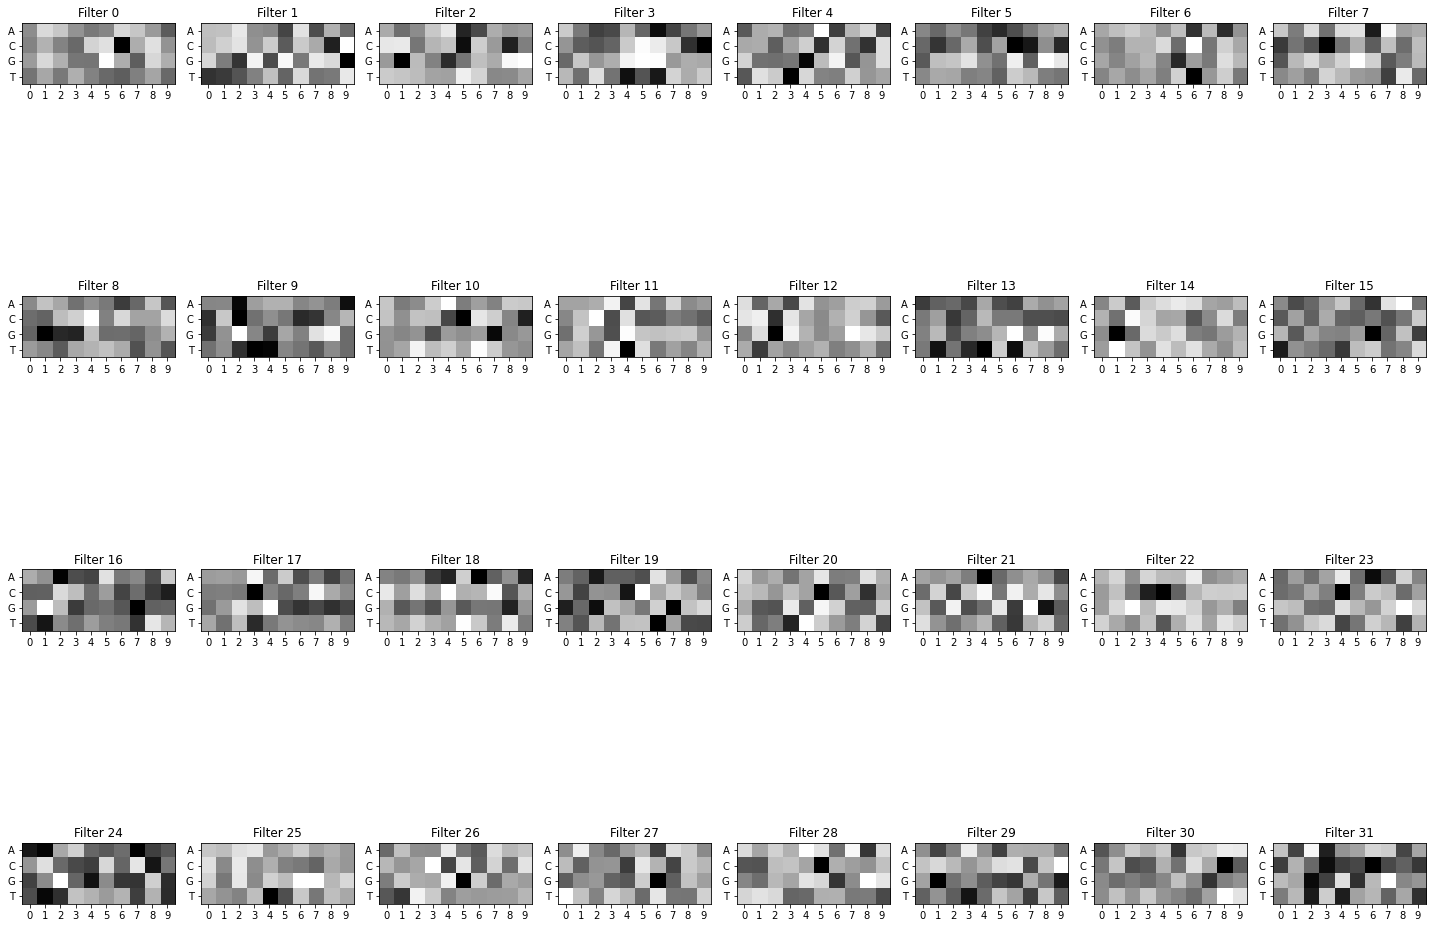

In [56]:
conv_layers, model_weights, bias_weights = get_conv_layers_from_model(t_res['model'])
view_filters(model_weights)

Thresh=1
Num filters 32
filt_width 10
Seq 0 of 3850
Seq 100 of 3850
Seq 200 of 3850
Seq 300 of 3850
Seq 400 of 3850
Seq 500 of 3850
Seq 600 of 3850
Seq 700 of 3850
Seq 800 of 3850
Seq 900 of 3850
Seq 1000 of 3850
Seq 1100 of 3850
Seq 1200 of 3850
Seq 1300 of 3850
Seq 1400 of 3850
Seq 1500 of 3850
Seq 1600 of 3850
Seq 1700 of 3850
Seq 1800 of 3850
Seq 1900 of 3850
Seq 2000 of 3850
Seq 2100 of 3850
Seq 2200 of 3850
Seq 2300 of 3850
Seq 2400 of 3850
Seq 2500 of 3850
Seq 2600 of 3850
Seq 2700 of 3850
Seq 2800 of 3850
Seq 2900 of 3850
Seq 3000 of 3850
Seq 3100 of 3850
Seq 3200 of 3850
Seq 3300 of 3850
Seq 3400 of 3850
Seq 3500 of 3850
Seq 3600 of 3850
Seq 3700 of 3850
Seq 3800 of 3850
torch.Size([32, 4, 10])
Thresh=0.5
Num filters 32
filt_width 10
Seq 0 of 3850
Seq 100 of 3850
Seq 200 of 3850
Seq 300 of 3850
Seq 400 of 3850
Seq 500 of 3850
Seq 600 of 3850
Seq 700 of 3850
Seq 800 of 3850
Seq 900 of 3850
Seq 1000 of 3850
Seq 1100 of 3850
Seq 1200 of 3850
Seq 1300 of 3850
Seq 1400 of 3850
Seq 

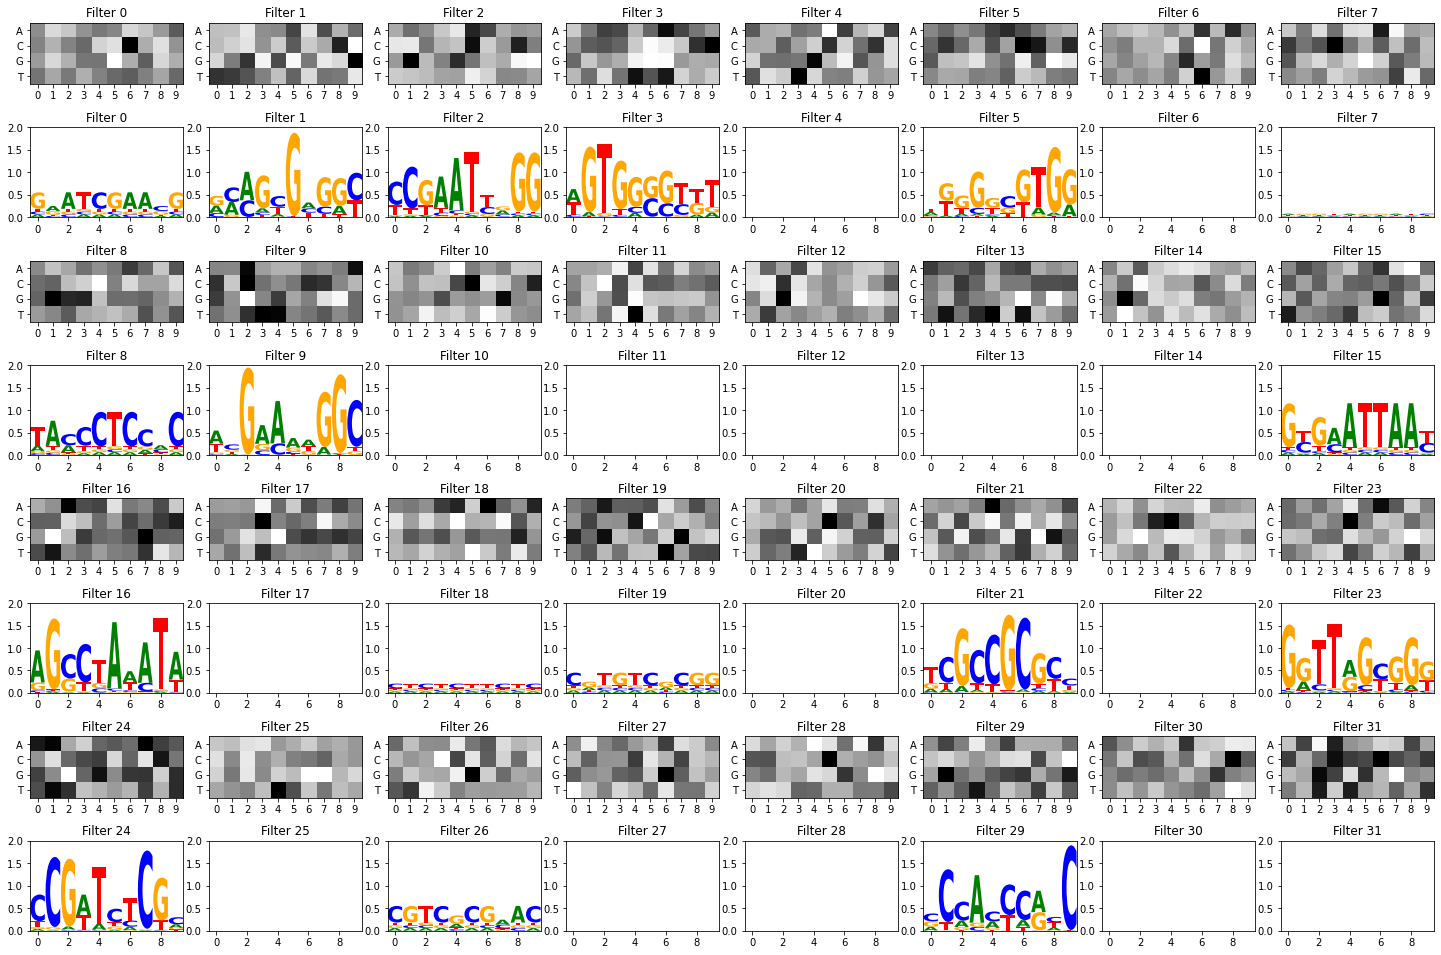

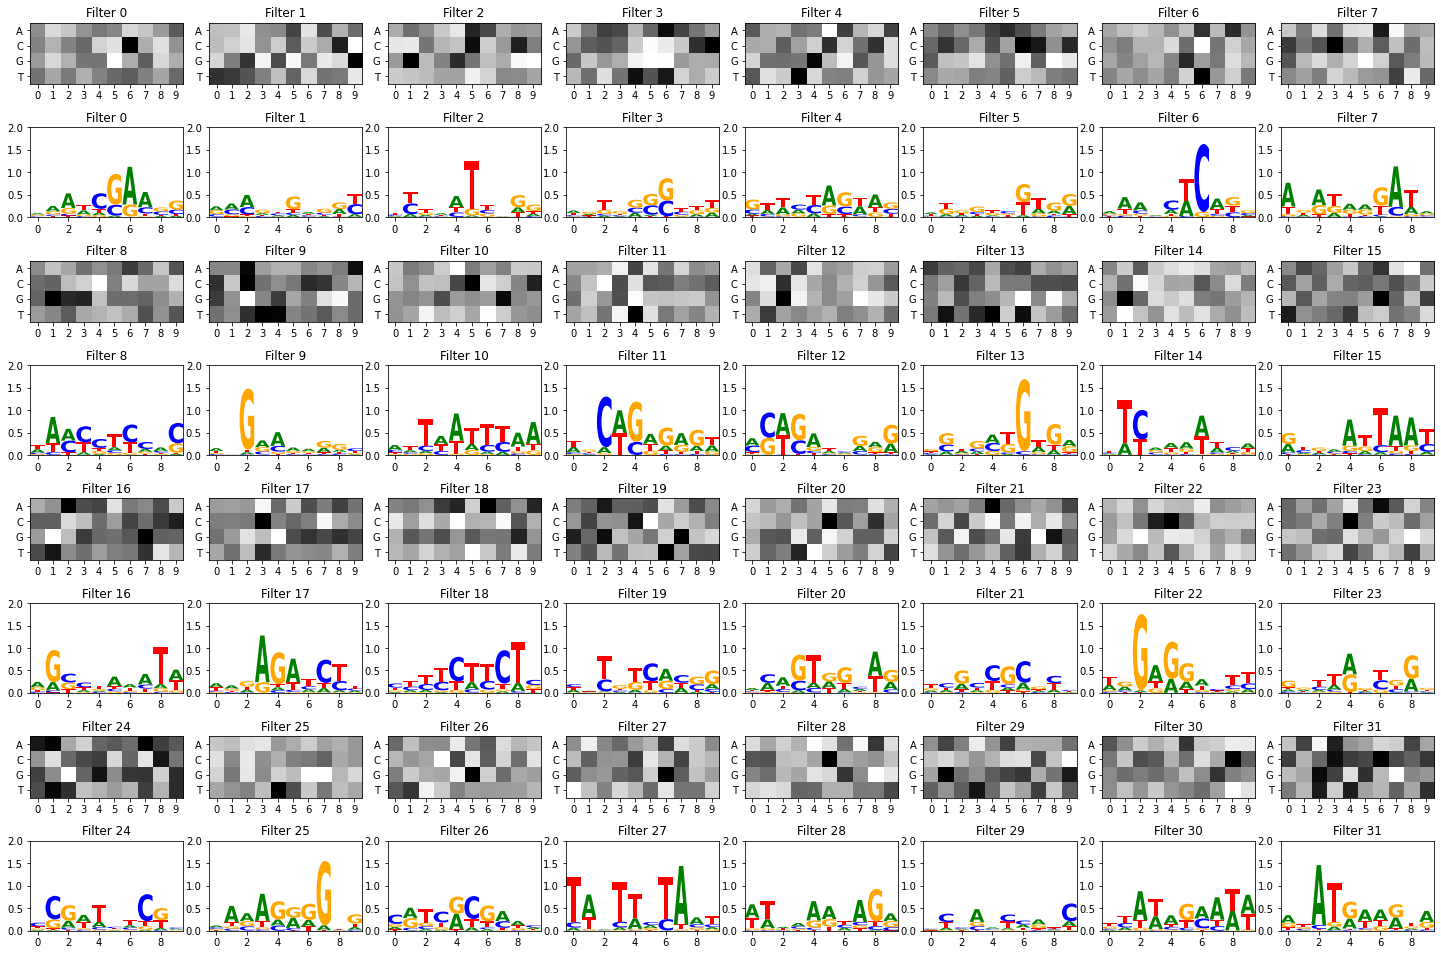

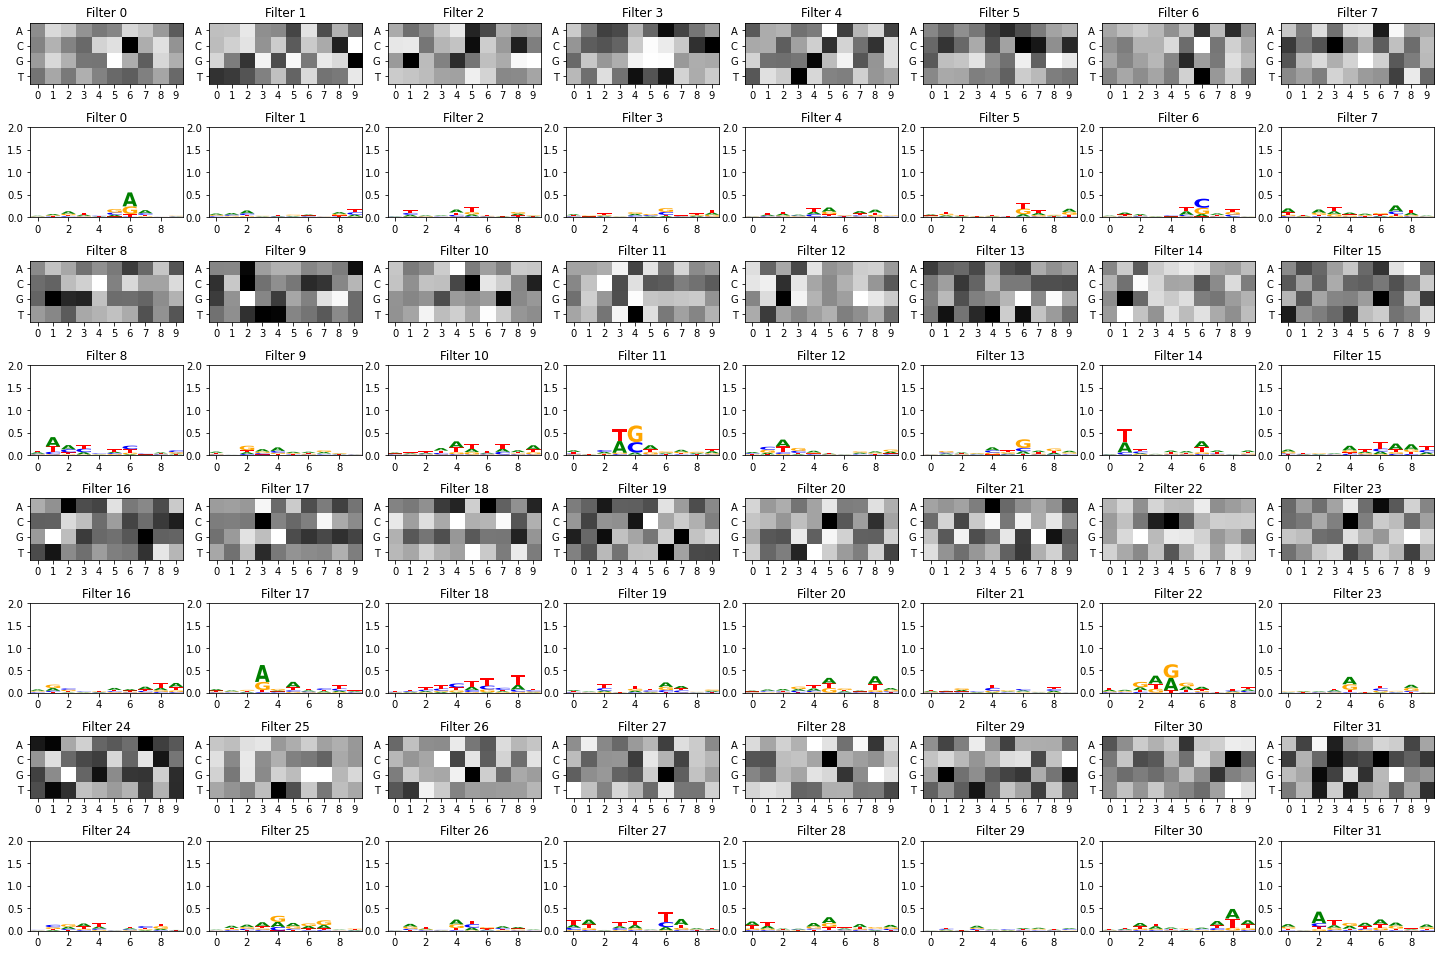

In [57]:
seqs = test_df["upstream_region"].values

print("Thresh=1")
filter_activations = get_filter_activations(seqs, conv_layers[0],act_thresh=1.0)
view_filters_and_logos(model_weights,filter_activations,ysc=0.75)

print("Thresh=0.5")
filter_activations = get_filter_activations(seqs, conv_layers[0],act_thresh=0.5)
view_filters_and_logos(model_weights,filter_activations,ysc=0.75)

print("Thresh=0")
filter_activations = get_filter_activations(seqs, conv_layers[0],act_thresh=0.0)
view_filters_and_logos(model_weights,filter_activations,ysc=0.75)


# Save the model

In [32]:
model = t_res['model']
opt = t_res['opt']

for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
    
# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in opt.state_dict():
    print(var_name, "\t", opt.state_dict()[var_name])

conv_net.0.weight 	 torch.Size([32, 1, 4, 10])
conv_net.0.bias 	 torch.Size([32])
conv_net.4.weight 	 torch.Size([32, 32, 1, 6])
conv_net.4.bias 	 torch.Size([32])
conv_net.8.weight 	 torch.Size([50, 4480])
conv_net.8.bias 	 torch.Size([50])
conv_net.10.weight 	 torch.Size([50, 50])
conv_net.10.bias 	 torch.Size([50])
conv_net.12.weight 	 torch.Size([5, 50])
conv_net.12.bias 	 torch.Size([5])
Optimizer's state_dict:
state 	 {140576937853728: {'step': 79376, 'exp_avg': tensor([[[[-2.7249e-03, -1.5039e-02, -1.1372e-02,  ..., -5.4302e-03,
           -5.0922e-03, -7.5195e-03],
          [-3.1162e-03, -2.2678e-03, -1.4629e-03,  ..., -8.8871e-03,
           -2.6740e-03, -1.6145e-03],
          [-7.3953e-03, -3.8910e-03, -3.7867e-03,  ..., -6.5321e-03,
           -8.1836e-03, -6.4120e-03],
          [-7.8148e-03,  1.4680e-04, -4.4296e-03,  ..., -2.0188e-04,
           -5.1014e-03, -5.5052e-03]]],


        [[[ 1.1443e-02,  8.8581e-03,  7.8530e-03,  ...,  3.6760e-03,
            4.0580e-03,  1

In [30]:
for child in model.named_children():
    print(child)

('conv_net', Sequential(
  (0): Conv2d(1, 32, kernel_size=(4, 10), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Dropout(p=0.25, inplace=False)
  (4): Conv2d(32, 32, kernel_size=(1, 6), stride=(1, 1))
  (5): ReLU()
  (6): Dropout(p=0.2, inplace=False)
  (7): Flatten()
  (8): Linear(in_features=4480, out_features=50, bias=True)
  (9): ReLU()
  (10): Linear(in_features=50, out_features=50, bias=True)
  (11): ReLU()
  (12): Linear(in_features=50, out_features=5, bias=True)
))


In [33]:
torch.save(model.state_dict(),'saved_models/5org_cls_cv0_model_state_dict.pt')
torch.save(opt.state_dict(),'saved_models/5org_cls_cv0_opt_state_dict.pt')

In [35]:
t_res.keys()

dict_keys(['model_name', 'model', 'opt', 'train_losses', 'val_losses', 'epoch_stop', 'best_val_score', 'data_label', 'total_time'])

In [37]:
WHOLE_PATH='saved_models/5org_cls_cv0_ALL.tar'

torch.save({
            'epoch': t_res['epoch_stop'],
            'model_state_dict': t_res['model'].state_dict(),
            'opt_state_dict': t_res['opt'].state_dict(),
            'loss': t_res['best_val_score'],
            }, WHOLE_PATH)

In [51]:
# RELOAD MODEL
model3 = m.DNA_2CNN_2FC_Multi(*m_args,**m_kwargs)
model3.load_state_dict(torch.load('saved_models/5org_cls_cv0_model_state_dict.pt'))

<All keys matched successfully>

Running 5org_cls_cnn


,model_name,split,mac_precision,mac_recall,mac_f1,support
0,5org_cls_cnn,train,0.953473,0.954590,0.953961,15399
1,5org_cls_cnn,test,0.858691,0.857774,0.858161,3850


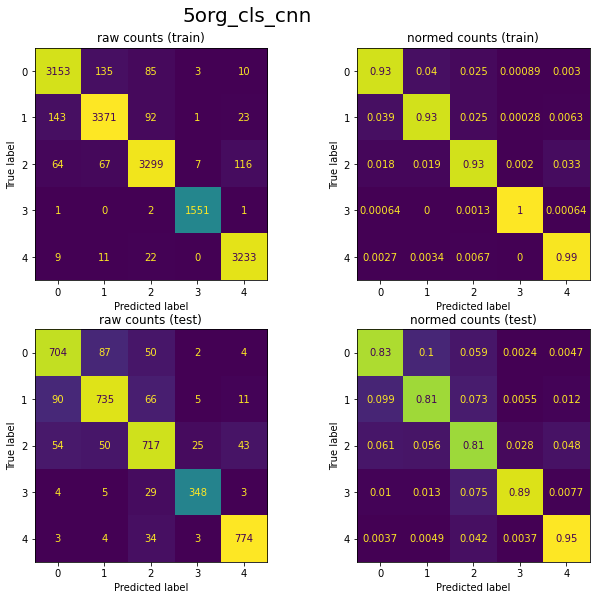

In [52]:
# confusion matrix plotting
seq_list = [
    (train_df["upstream_region"].values,train_df["id"],"train"),
    (test_df["upstream_region"].values,test_df["id"],"test")
]
p_res_df = get_confusion_stats(
    model3.to(DEVICE),
    t_res['model_name'],
    seq_list,
    title=f"{t_res['model_name']}"
)

p_res_df

In [ ]:
# ok, successfully loaded warm version of model into model3.
# now can I make model 4 with my alternate prediction head?

In [56]:
model4 = m.DNA_2CNN_2FC_Multi(seq_len, 3,**m_kwargs)
model4.load_state_dict(torch.load('saved_models/5org_cls_cv0_model_state_dict.pt'),strict=False)

RuntimeError: Error(s) in loading state_dict for DNA_2CNN_2FC_Multi:
	size mismatch for conv_net.12.weight: copying a param with shape torch.Size([5, 50]) from checkpoint, the shape in current model is torch.Size([3, 50]).
	size mismatch for conv_net.12.bias: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([3]).

In [54]:
model4

DNA_2CNN_2FC_Multi(
  (conv_net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 10), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.25, inplace=False)
    (4): Conv2d(32, 32, kernel_size=(1, 6), stride=(1, 1))
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): Flatten()
    (8): Linear(in_features=4480, out_features=50, bias=True)
    (9): ReLU()
    (10): Linear(in_features=50, out_features=50, bias=True)
    (11): ReLU()
    (12): Linear(in_features=50, out_features=3, bias=True)
  )
)

## Load 5G data

In [4]:
locus2info['EQU24_RS19315']

{'gene': 'pmoC',
 'product': 'methane monooxygenase/ammonia monooxygenase subunit C',
 'type': 'CDS'}

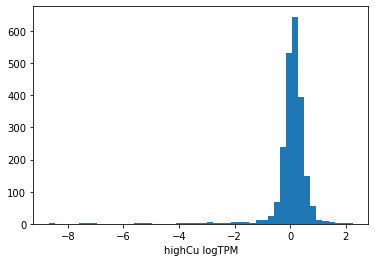

In [5]:
plt.hist(XYdf_og['highCu'],bins=50)
plt.xlabel("highCu logTPM")
plt.show()

In [6]:
XYdf_og[XYdf_og['upstream_region'].str.contains("N")]

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,...,WithLanthanum,NoLanthanum,LanzaTech,aa3_KO,crotonic_acid,CH4_500ppm,CH4_1000ppm,gene,product,type
2112,4034,EQU24_RS22155,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0.424743,0.303697,-0.879836,-1.737032,0.0,0.574217,0.743902,...,-1.594517,-1.543377,-0.605951,-0.528291,-0.482834,-2.07773,-2.524997,rpmH,50S ribosomal protein L34,CDS


In [7]:
# remove seq with N's for now
XYdf = XYdf_og[~XYdf_og['upstream_region'].str.contains("N")]
XYdf

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,...,WithLanthanum,NoLanthanum,LanzaTech,aa3_KO,crotonic_acid,CH4_500ppm,CH4_1000ppm,gene,product,type
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,0.333441,-0.087509,-0.248330,-0.654293,0.0,0.252788,0.260753,...,-0.117634,-0.180709,-0.516711,-0.472602,0.058102,0.668619,0.215153,dnaA,chromosomal replication initiator protein DnaA,CDS
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,0.179318,-0.183682,-0.493245,-1.323530,0.0,0.418315,0.611021,...,-0.244793,-0.161434,0.237179,-0.079076,0.132689,-0.462317,-0.490073,dnaN,DNA polymerase III subunit beta,CDS
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,0.364849,0.170159,-0.338861,-0.347147,0.0,0.287824,0.387577,...,-0.249011,-0.066333,-0.987336,-0.990306,0.481623,0.144467,-0.239513,recF,DNA replication/repair protein RecF,CDS
3,4,EQU24_RS00035,GTATAAACCATGAAAGTCAGCCTATTTCGAAGATACCGACACCCTA...,0.193539,0.035923,0.136026,-0.642058,0.0,0.189394,0.345084,...,0.643283,0.566397,-0.952383,-0.465515,0.009531,0.367039,0.695145,NaN,hypothetical protein,CDS
4,9,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,0.173256,0.283822,-0.740565,-1.011908,0.0,0.215938,0.306791,...,0.539188,0.622656,-0.716034,-0.025042,0.070784,-0.367242,-0.319915,NaN,bifunctional diguanylate cyclase/phosphodieste...,CDS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2206,4182,EQU24_RS23145,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,0.620221,0.718300,0.245892,-1.598809,0.0,0.171579,0.501296,...,0.977712,1.564370,0.701928,1.577361,0.777911,0.463434,0.727701,hxlA,3-hexulose-6-phosphate synthase,CDS
2207,4184,EQU24_RS23155,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,0.609995,0.702416,0.231606,-1.614646,0.0,0.154029,0.483579,...,0.952955,1.548383,0.701457,1.573150,0.761210,0.433925,0.705205,hxlA,3-hexulose-6-phosphate synthase,CDS
2208,4186,EQU24_RS23165,TTGAAACCCTAAGGTACATTGAGGCGTTAGCAAAGAGCAAGTTTGA...,0.605448,0.688065,0.233752,-1.594922,0.0,0.171939,0.486032,...,0.899683,1.442487,0.708730,1.520411,0.769644,0.032260,0.305817,hxlA,3-hexulose-6-phosphate synthase,CDS
2209,4187,EQU24_RS23170,AATCTTCATTAGAGTCGAACGAAGTTTCATGTTTTCGGCTTCCTCA...,0.604488,0.196871,-0.261330,0.125607,0.0,-0.014653,0.229101,...,-0.233161,0.107133,0.265191,-0.870372,0.814080,-0.245552,-0.285502,NaN,transposase,CDS


In [11]:
def set_reg_class_up_down(df, col,thresh=1.0):
    '''
    Given a dataframe of log ratio TPMS, add a column splitting genes into categories
    * Below -thresh: class 0
    * Between -thresh:thresh: class 1
    * Above thresh: class 2
    '''
    def get_class(val):
        if val < -thresh:
            return 0
        elif val > thresh:
            return 2
        else:
            return 1
    
    reg_col = f"{col}_reg_UD"
    df[reg_col] = df[col].apply(lambda x: get_class(x))

In [12]:
set_reg_class_up_down(XYdf,'score',thresh=5)
XYdf

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,...,LanzaTech,aa3_KO,crotonic_acid,CH4_500ppm,CH4_1000ppm,gene,product,type,score,score_reg_UD
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,0.333441,-0.087509,-0.248330,-0.654293,0.0,0.252788,0.260753,...,-0.516711,-0.472602,0.058102,0.668619,0.215153,dnaA,chromosomal replication initiator protein DnaA,CDS,-0.563333,1
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,0.179318,-0.183682,-0.493245,-1.323530,0.0,0.418315,0.611021,...,0.237179,-0.079076,0.132689,-0.462317,-0.490073,dnaN,DNA polymerase III subunit beta,CDS,-0.130000,1
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,0.364849,0.170159,-0.338861,-0.347147,0.0,0.287824,0.387577,...,-0.987336,-0.990306,0.481623,0.144467,-0.239513,recF,DNA replication/repair protein RecF,CDS,-0.073333,1
3,4,EQU24_RS00035,GTATAAACCATGAAAGTCAGCCTATTTCGAAGATACCGACACCCTA...,0.193539,0.035923,0.136026,-0.642058,0.0,0.189394,0.345084,...,-0.952383,-0.465515,0.009531,0.367039,0.695145,NaN,hypothetical protein,CDS,0.220000,1
4,9,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,0.173256,0.283822,-0.740565,-1.011908,0.0,0.215938,0.306791,...,-0.716034,-0.025042,0.070784,-0.367242,-0.319915,NaN,bifunctional diguanylate cyclase/phosphodieste...,CDS,-0.146667,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2206,4182,EQU24_RS23145,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,0.620221,0.718300,0.245892,-1.598809,0.0,0.171579,0.501296,...,0.701928,1.577361,0.777911,0.463434,0.727701,hxlA,3-hexulose-6-phosphate synthase,CDS,0.383333,1
2207,4184,EQU24_RS23155,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,0.609995,0.702416,0.231606,-1.614646,0.0,0.154029,0.483579,...,0.701457,1.573150,0.761210,0.433925,0.705205,hxlA,3-hexulose-6-phosphate synthase,CDS,0.383333,1
2208,4186,EQU24_RS23165,TTGAAACCCTAAGGTACATTGAGGCGTTAGCAAAGAGCAAGTTTGA...,0.605448,0.688065,0.233752,-1.594922,0.0,0.171939,0.486032,...,0.708730,1.520411,0.769644,0.032260,0.305817,hxlA,3-hexulose-6-phosphate synthase,CDS,-0.220000,1
2209,4187,EQU24_RS23170,AATCTTCATTAGAGTCGAACGAAGTTTCATGTTTTCGGCTTCCTCA...,0.604488,0.196871,-0.261330,0.125607,0.0,-0.014653,0.229101,...,0.265191,-0.870372,0.814080,-0.245552,-0.285502,NaN,transposase,CDS,-0.236667,1


In [13]:
XYdf['score_reg_UD'].value_counts()

1    1953
2     169
0      88
Name: score_reg_UD, dtype: int64

In [14]:
set_reg_class_up_down(XYdf,'highCu',thresh=0.6)
XYdf['highCu_reg_UD'].value_counts()


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1    1957
2     158
0      95
Name: highCu_reg_UD, dtype: int64

### Train/val/test splitting

In [15]:
def plot_train_test_hist(train_df, test_df,val_df=None,score_col='score',bins=10):
    ''' Check distribution of train/test scores, sanity check that its not skewed'''
    plt.hist(train_df[score_col].values,bins=bins,label="train")
    plt.hist(test_df[score_col].values,bins=bins,label='test')
    if val_df is not None:
        plt.hist(val_df[score_col].values,bins=bins,label='val')
    plt.legend()
    plt.xlabel("seq score",fontsize=14)
    plt.ylabel("count",fontsize=14)
    plt.show()

def view_train_test_dist(train_df,test_df,score_cols,title,id_col='locus_tag',val_df=None):
    train_df['set'] = 'train'
    test_df['set'] = 'test'
    if val_df is not None:
        val_df['set'] = "val"
        df = pd.concat([train_df,test_df,val_df])
    else:
        df = pd.concat([train_df,test_df])
    
    df_melt = pd.melt(df, id_vars=[id_col,'set'],value_vars=score_cols,var_name='cond',value_name='score')
    
    sns.stripplot(data=df_melt,x='cond',y='score',hue='set',dodge=True,alpha=0.2)
    plt.title(f"{title} distribution")
    plt.show()
    
    sns.violinplot(data=df_melt,x='cond',y='score',hue='set',dodge=True,alpha=0.2)
    plt.title(f"{title} distribution")
    plt.show()
    
#     sns.boxplot(data=df_melt,x='cond',y='score',hue='set',dodge=True)
#     plt.title(f"{title} distribution")
#     plt.show()
    sns.countplot(data=df_melt,x='score',hue='set')
    plt.title(f"{title} counts")
    plt.show()

In [16]:
def shuffle_seq(dna):
    to_shuffle = list(dna)
    random.shuffle(to_shuffle)
    return  ''.join(to_shuffle)

XYdf['shuffled_seq'] = XYdf['upstream_region'].apply(lambda x: shuffle_seq(x))
XYdf[['upstream_region','shuffled_seq']]

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,upstream_region,shuffled_seq
0,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,GTCTTCTGAGTGTTATAAGCTGGAGTTCTTCAGTGTTGTGTACCCA...
1,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,TTGATGTGTATATTGGACCTAACTACGCAAACCTTTGTCCTTGTAA...
2,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,TAGGCAGACTTGGTAAGGTTCGTATTAGATGTCAAAGTAAGAGGTA...
3,GTATAAACCATGAAAGTCAGCCTATTTCGAAGATACCGACACCCTA...,ACCATGCTAGACCATTCTCTAAAGCACATCTAGAGGTTACTTGTTA...
4,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,ATTTATGAAGATACTACTACGCCAACACGCCTTTTCTGCTCGAATG...
...,...,...
2206,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,CGGTTCCGTCGCTACATAAACATATATATTCCCACGGAACACCGAC...
2207,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,CAAAATGTCAATCTGGTGTCTGAAAACGGCGCATCCAAAGATCGCT...
2208,TTGAAACCCTAAGGTACATTGAGGCGTTAGCAAAGAGCAAGTTTGA...,TGAGTGTACTAAACCAACAATCCAACTGATCGACTGCCATTTGAAA...
2209,AATCTTCATTAGAGTCGAACGAAGTTTCATGTTTTCGGCTTCCTCA...,GGGTGTTCATATGTGACGTTCAGCTTATTACGCCTCAGAGTTGATA...


In [18]:
XYdf['score_shuff'] = XYdf['shuffled_seq'].apply(lambda x: score_seq(x))
set_reg_class_up_down(XYdf,'score_shuff',thresh=5)
XYdf['score_shuff_reg_UD'].value_counts()


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1    1868
2     275
0      67
Name: score_shuff_reg_UD, dtype: int64

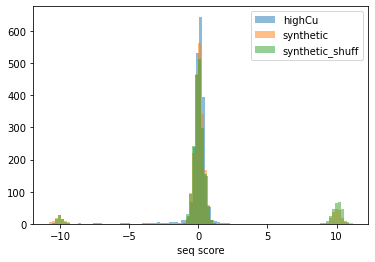

In [19]:
plt.hist(XYdf['highCu'],bins=50,alpha=0.5,label='highCu')
plt.hist(XYdf['score'],bins=100,alpha=0.5,label='synthetic')
plt.hist(XYdf['score_shuff'],bins=100,alpha=0.5,label='synthetic_shuff')
plt.xlabel("seq score")
plt.legend()
plt.show()

In [20]:
from sklearn.model_selection import GroupKFold,GroupShuffleSplit,StratifiedKFold #StratifiedGroupKFold

In [21]:
#skf = StratifiedKFold(n_splits=5)
skf_shuff = StratifiedKFold(n_splits=5)

_____Split 0____


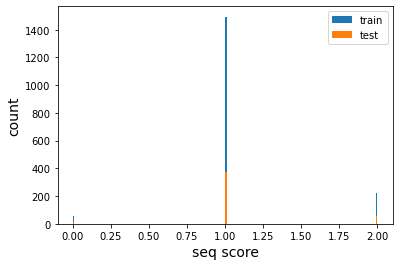

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this

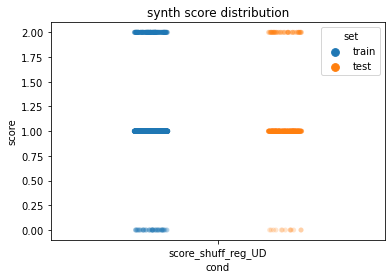

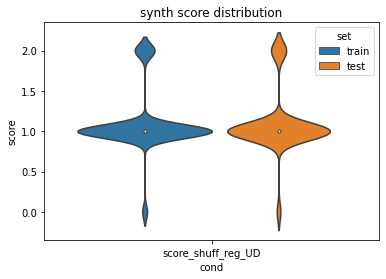

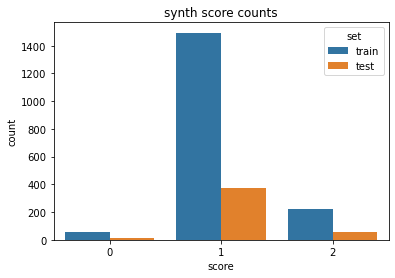


_____Split 1____


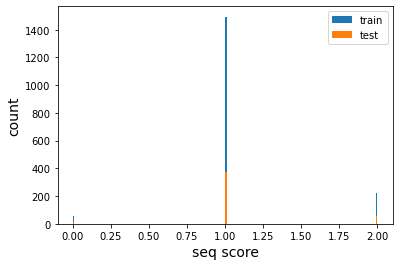

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this

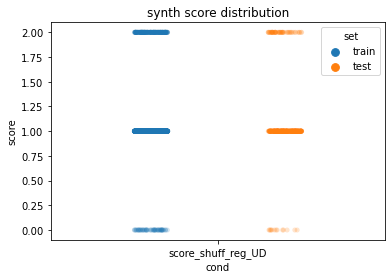

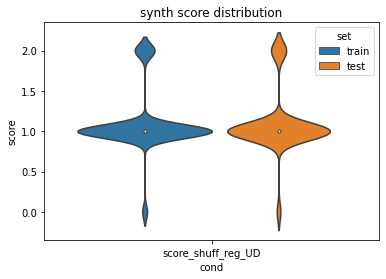

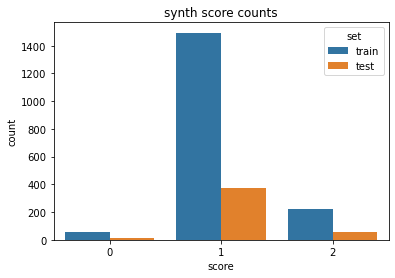


_____Split 2____


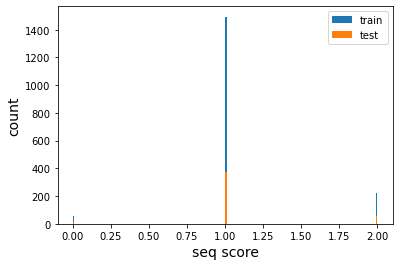

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this

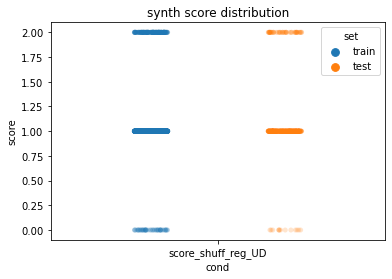

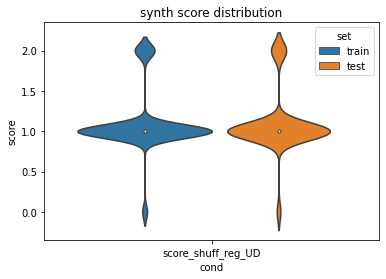

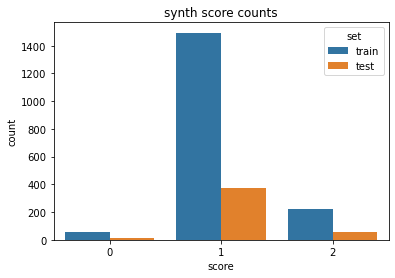


_____Split 3____


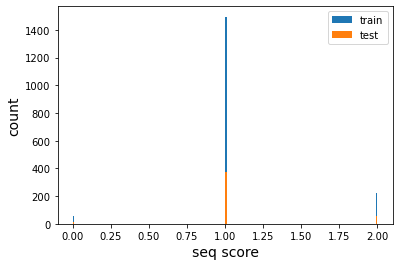

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this

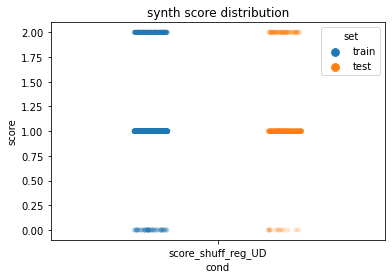

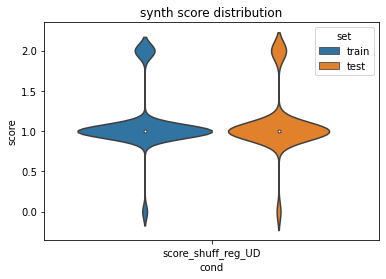

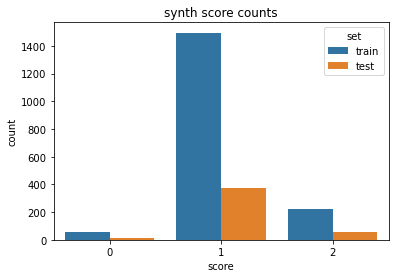


_____Split 4____


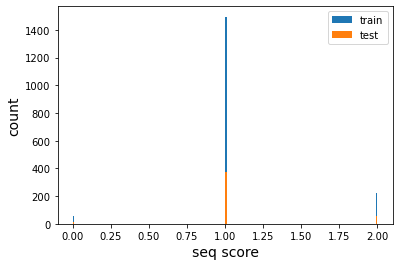

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this

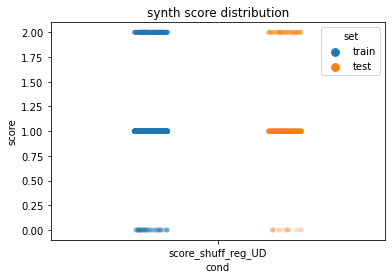

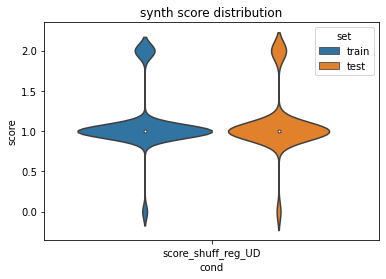

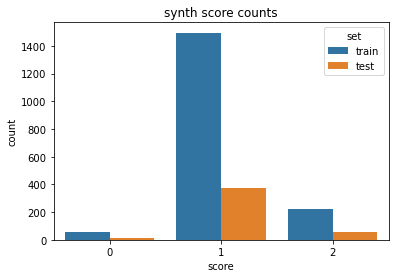

In [22]:
# for i, (train_idxs, test_idxs) in enumerate(skf.split(XYdf, XYdf['score_reg_UD'])):
#     print(f"_____Split {i}____")
#     train_df = XYdf.iloc[train_idxs]
#     test_df = XYdf.iloc[test_idxs]
    
#     score_col = "score_reg_UD"

#     plot_train_test_hist(train_df, test_df,score_col=score_col,bins=200)
#     view_train_test_dist(train_df, test_df,[score_col],"synth score",id_col='locus_tag')
    
#     print("")
    
#     split_dfs = {
#         'train':train_df,
#         'test':test_df
#     }
    
#     train_df.to_csv(f'data/synth_cls_splits/cv{i}_train.tsv',index=False,sep='\t')
#     test_df.to_csv(f'data/synth_cls_splits/cv{i}_test.tsv',index=False,sep='\t')

for i, (train_idxs, test_idxs) in enumerate(skf_shuff.split(XYdf, XYdf['score_shuff_reg_UD'])):
    print(f"_____Split {i}____")
    train_df = XYdf.iloc[train_idxs]
    test_df = XYdf.iloc[test_idxs]
    
    score_col = "score_shuff_reg_UD"

    plot_train_test_hist(train_df, test_df,score_col=score_col,bins=200)
    view_train_test_dist(train_df, test_df,[score_col],"synth score",id_col='locus_tag')
    
    print("")
    
    split_dfs = {
        'train':train_df,
        'test':test_df
    }
    
    train_df.to_csv(f'data/synth_cls_splits/cv{i}_shuff_train.tsv',index=False,sep='\t')
    test_df.to_csv(f'data/synth_cls_splits/cv{i}_shuff_test.tsv',index=False,sep='\t')



In [23]:
test_df['score_reg_UD'].value_counts()

1    402
0     20
2     20
Name: score_reg_UD, dtype: int64

In [24]:
test_df['score_shuff_reg_UD'].value_counts()

1    373
2     55
0     14
Name: score_shuff_reg_UD, dtype: int64

## Load 5G seqs into data loaders

In [22]:
dataset_types = [
    DatasetSpec('ohe'),
#     DatasetSpec('kmer',k=3),
#     DatasetSpec('kmer',k=6),
]

In [23]:
seq_col_name = 'upstream_region'
target_col_name = 'score_reg_UD'

# Dfs for the full train/test split
# final_dls = tu.build_dataloaders_single(
#     full_train_df, 
#     test_df, 
#     dataset_types,
#     seq_col=seq_col_name,
#     target_col=target_col_name
# )

# Dfs from further spliting train into train and val
dls = tu.build_dataloaders_single(
    train_df, 
    test_df, 
    dataset_types,
    seq_col=seq_col_name,
    target_col=target_col_name,
)

# log_kmer6_train_dl,log_kmer6_val_dl = log_dls['kmer_6']
# log_kmer3_train_dl,log_kmer3_val_dl = log_dls['kmer_3']
ohe_train_dl,ohe_val_dl = dls['ohe']

## Run models

In [24]:
def collect_model_stats(model_name,seq_len,encoding,
                        train_dl,val_dl,
                        lr=0.001,ep=1000,pat=100,
                        opt=None,model=None,load_best=False):
    
    if not model:
        model = m.DNA_2CNN_2FC_Multi(
            seq_len,
            3, # num tasks
        )
    model.to(DEVICE)

    #loss_func = torch.nn.MSELoss() 
    loss_func = torch.nn.CrossEntropyLoss()
    
    if opt:
        opt = opt(model.parameters(), lr=lr)

    # pass in
    #train_dl,val_dl = dls[encoding] 
    
    train_losses, \
    val_losses, \
    epoch_stop, \
    best_val_score = tu.run_model(
        train_dl,
        val_dl, 
        model, 
        loss_func, 
        DEVICE,
        lr=lr, 
        epochs=ep, 
        opt=opt,
        patience=pat,
        load_best=load_best # leave false to see overfitting in parity plots
    )

    # to plot loss
    data_label = [((train_losses,val_losses),model_name,epoch_stop,best_val_score)]
    tu.quick_loss_plot(data_label)
    
    return {
        'model_name':model_name,
        'model':model,
        'train_losses':train_losses,
        'val_losses':val_losses,
        'epoch_stop':epoch_stop,
        'best_val_score':best_val_score,
        'data_label':data_label
    }

In [25]:
# def parity_pred_by_split(model_name,
#                          device,
#                          split_dfs,
#                          locus_col='locus_tag',
#                          seq_col='seq',
#                          target_col="score",
#                          splits=['train','val'],
#                          alpha=0.2
#                         ):
#     '''
#     Given a trained model, get the model's predictions on each split
#     of the data and create parity plots of the y predictions vs actual ys
#     '''
#     # init subplots
#     fig, axs = plt.subplots(1,len(splits), sharex=True, sharey=True,figsize=(10,4))
#     pred_dfs = {}
    
#     def parity_plot(model_title,ytrue,ypred,rigid=True):
#         axs[i].scatter(ytrue, ypred, alpha=alpha)

#         r2 = r2_score(ytrue,ypred)
#         pr = pearsonr(ytrue,ypred)[0]
#         sp = spearmanr(ytrue,ypred).correlation

#         # y=x line
#         xpoints = ypoints = plt.xlim()
#         if rigid:
#             axs[i].set_ylim(min(xpoints),max(xpoints)) 
#         axs[i].plot(xpoints, ypoints, linestyle='--', color='k', lw=2, scalex=False, scaley=False)
#         axs[i].set_title(f"{model_title} (r2:{r2:.2f}|p:{pr:.2f}|sp:{sp:.2f})",fontsize=14)
#         axs[i].set_xlabel("Actual Score",fontsize=14)
#         axs[i].set_ylabel("Predicted Score",fontsize=14)
    
#     for i,split in enumerate(splits):
#         print(f"{split} split")
#         df = split_dfs[split]
#         loci = df[locus_col].values
#         seqs = list(df[seq_col].values)        
#         ohe_seqs = torch.stack([torch.tensor(u.one_hot_encode(x)) for x in seqs]).to(device)
#         labels = torch.tensor(list(df[target_col].values)).unsqueeze(1)
    
#     #dfs = {} # key: model name, value: parity_df
    
#         # initialize prediction df with just locus col
#         pred_df = df[[locus_col]]
#         pred_df['truth'] = df[target_col]
#         print(f"Running {model_name}")
        
#         model = model_res[model_name]['model']
#         # ask model to predict on seqs
#         preds = model(ohe_seqs.float()).tolist()
#         # preds is a tensor converted to a list, 
#         # single elements returned as a list, hence x[0]
#         pred_df['pred'] = [x[0] for x in preds]
        
#         # do I want the result dfs? revise if so
#         #dfs[model_name] = pred_df
        
#         # plot stuff
#         ytrue = pred_df['truth'].values
#         ypred = pred_df['pred'].values
        
#         #plt.subplot(len(splits),i+1,1)
#         model_title = split
#         parity_plot(model_title,ytrue,ypred,rigid=True)
        
#         # save predictions
#         pred_dfs[split] = pred_df
    
    
#     plt.suptitle(model_name,fontsize=14)
#     plt.tight_layout()
#     plt.show()
    
#     return pred_dfs

In [26]:
model_res = {}
pred_dfs = {}
seq_len = len(train_df[seq_col_name].values[0])

E:646 | train loss:0.432 | val loss: 0.438:  32%|███▏      | 647/2000 [00:39<01:19, 17.03it/s]

EarlyStopping counter: 50 out of 200


E:696 | train loss:0.432 | val loss: 0.438:  35%|███▍      | 697/2000 [00:42<01:16, 16.97it/s]

EarlyStopping counter: 100 out of 200


E:749 | train loss:0.432 | val loss: 0.438:  37%|███▋      | 749/2000 [00:45<01:13, 16.98it/s]

EarlyStopping counter: 50 out of 200


E:799 | train loss:0.432 | val loss: 0.438:  40%|███▉      | 799/2000 [00:48<01:10, 17.00it/s]

EarlyStopping counter: 100 out of 200


E:849 | train loss:0.432 | val loss: 0.438:  42%|████▏     | 849/2000 [00:51<01:07, 17.07it/s]

EarlyStopping counter: 150 out of 200


E:896 | train loss:0.431 | val loss: 0.438:  45%|████▍     | 896/2000 [00:54<01:07, 16.44it/s]


EarlyStopping counter: 200 out of 200
Early stopping


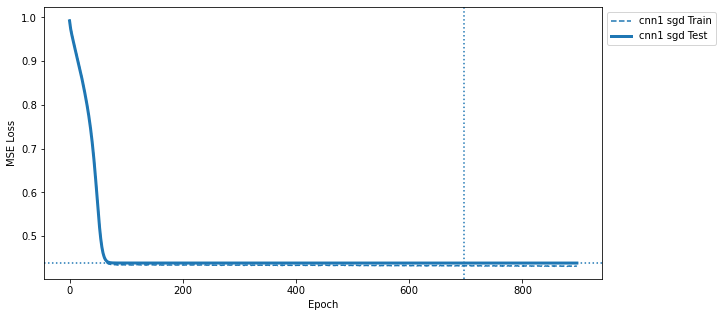

In [27]:
cnn1_name = 'cnn1 sgd'
model_res[cnn1_name] = collect_model_stats(
    cnn1_name,
    seq_len,
    'ohe',
    ohe_train_dl,
    ohe_val_dl,
    lr=0.001,
    ep=2000,
    pat=200,
)

In [34]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report

In [101]:
def get_confusion_stats(model,model_name,seq_list,save_file=False):#seqs,labels,seq_name):
    '''Get class predictions and plot confusion matrix'''

    def plot_confusion_raw_norm(mats):
        f, axes = plt.subplots(len(seq_list), 2, figsize=(9.8, 4.2*len(seq_list)))#, sharey='row')
        #axes = list(axes)
        axes_list = [item for sublist in axes for item in sublist]

        for i,(mat,title) in enumerate(mats):
            disp = ConfusionMatrixDisplay(confusion_matrix=mat)
            disp.plot(ax=axes_list.pop(0))
            #disp.plot(ax=axes.pop(0))
            disp.ax_.set_title(f"{title}")
            disp.im_.colorbar.remove()

        f.suptitle(f"{model_name}",fontsize=20)
        plt.tight_layout()
        if save_file:
            plt.savefig(save_file)

    model.eval()
    print(f"Running {model_name}")
    
    mats = [] # conf matrices
    res_data = [] # classification results

    for seqs, labels, split_name in seq_list:
        ohe_seqs = torch.stack([torch.tensor(u.one_hot_encode(x)) for x in seqs]).to(DEVICE)
        preds = [x.topk(1).indices.item() for x in model(ohe_seqs.float())]#.tolist()        
        
        cls_rep = classification_report(labels, preds,output_dict=True)
        pr = cls_rep['macro avg']['precision']
        re = cls_rep['macro avg']['recall']
        f1 = cls_rep['macro avg']['f1-score']
        sp = cls_rep['macro avg']['support']
        res_data.append([model_name,split_name,pr,re,f1,sp])
        
        c = confusion_matrix(labels, preds)
        mats.append((c,f"raw counts ({split_name})"))
        # get the normalized confusino matrix
        cp = np.zeros(c.shape)
        for i,row in enumerate(c):
            rowsum = sum(row)
            for j,item in enumerate(row):
                val = item/rowsum
                cp[i][j] = val

        mats.append((cp,f"normed counts ({split_name})"))

    plot_confusion_raw_norm(mats)
    
    res_df = pd.DataFrame(res_data,columns=['model_name','split','mac_precision','mac_recall','mac_f1','support'])
    
    
    return res_df

Running cnn1 sgd


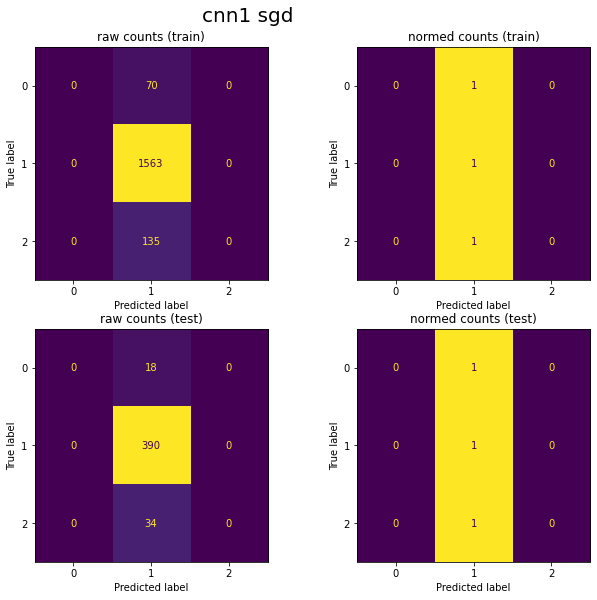

In [102]:
seq_list = [
    (train_df['upstream_region'].values,train_df['score_reg_UD'],"train"),
    (test_df['upstream_region'].values,test_df['score_reg_UD'],"test")
]

rep = get_confusion_stats(
    model_res[cnn1_name]['model'],
    cnn1_name,
    seq_list
)

In [103]:
rep

,model_name,split,mac_precision,mac_recall,mac_f1,support
0,cnn1 sgd,train,0.294683,0.333333,0.312819,1768
1,cnn1 sgd,test,0.294118,0.333333,0.312500,442


In [42]:
rep

{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 70},
 '1': {'precision': 0.8840497737556561,
  'recall': 1.0,
  'f1-score': 0.9384569198438907,
  'support': 1563},
 '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 135},
 'accuracy': 0.8840497737556561,
 'macro avg': {'precision': 0.29468325791855204,
  'recall': 0.3333333333333333,
  'f1-score': 0.3128189732812969,
  'support': 1768},
 'weighted avg': {'precision': 0.7815440024774267,
  'recall': 0.8840497737556561,
  'f1-score': 0.8296426276674215,
  'support': 1768}}

Running cnn1 sgd


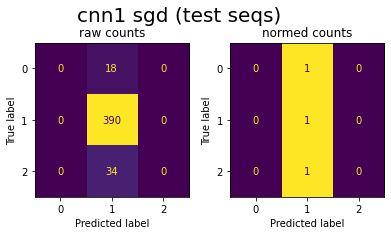

In [31]:
plot_confusion_raw_norm(
    model_res[cnn1_name]['model'],
    cnn1_name,
    test_df['upstream_region'].values,
    test_df['score_reg_UD'],
    "test seqs"
)

In [ ]:
cls_rep = classification_report(ys, y_preds,target_names=imods,output_dict=True)

E:131 | train loss:0.001 | val loss: 1.918:   3%|▎         | 132/5000 [00:08<05:06, 15.90it/s]

EarlyStopping counter: 125 out of 500


E:256 | train loss:0.001 | val loss: 2.038:   5%|▌         | 256/5000 [00:16<04:57, 15.92it/s]

EarlyStopping counter: 250 out of 500


E:381 | train loss:0.000 | val loss: 2.459:   8%|▊         | 382/5000 [00:24<04:49, 15.96it/s]

EarlyStopping counter: 375 out of 500


E:503 | train loss:0.000 | val loss: 2.677:  10%|█         | 503/5000 [00:31<04:43, 15.86it/s]


EarlyStopping counter: 500 out of 500
Early stopping


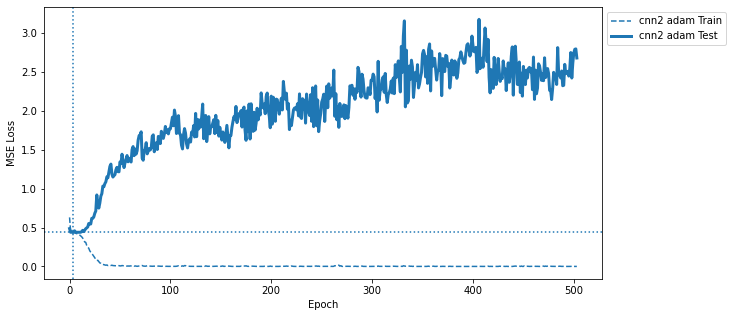

In [104]:
cnn2_name = 'cnn2 adam'
model_res[cnn2_name] = collect_model_stats(
    cnn2_name,
    seq_len,
    'ohe',
    ohe_train_dl,
    ohe_val_dl,
    lr=0.001,
    ep=5000,
    pat=500,
    opt=torch.optim.Adam
)

Running cnn2 adam
Running cnn2 adam


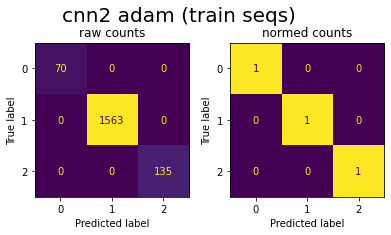

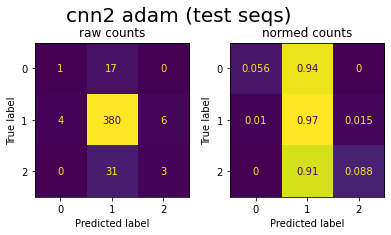

In [105]:
plot_confusion_raw_norm(
    model_res[cnn2_name]['model'],
    cnn2_name,
    train_df['upstream_region'].values,
    train_df['score_reg_UD'],
    "train seqs"
)

plot_confusion_raw_norm(
    model_res[cnn2_name]['model'],
    cnn2_name,
    test_df['upstream_region'].values,
    test_df['score_reg_UD'],
    "test seqs"
)

E:159 | train loss:0.258 | val loss: 0.540:   3%|▎         | 160/5000 [00:10<05:02, 16.02it/s]

EarlyStopping counter: 125 out of 500


E:284 | train loss:0.088 | val loss: 0.859:   6%|▌         | 284/5000 [00:17<04:52, 16.12it/s]

EarlyStopping counter: 250 out of 500


E:409 | train loss:0.019 | val loss: 1.210:   8%|▊         | 410/5000 [00:25<04:47, 15.96it/s]

EarlyStopping counter: 375 out of 500


E:531 | train loss:0.006 | val loss: 1.362:  11%|█         | 531/5000 [00:33<04:40, 15.91it/s]


EarlyStopping counter: 500 out of 500
Early stopping


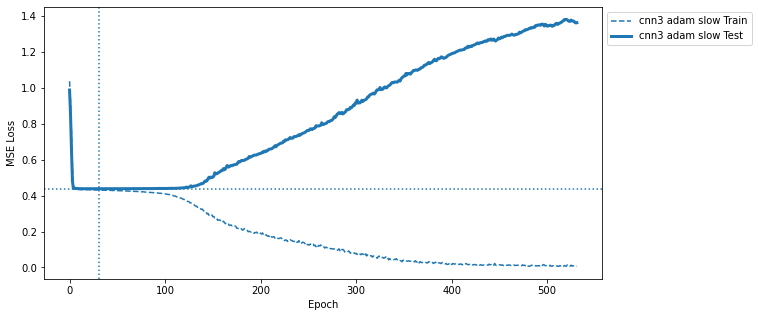

In [106]:
cnn3_name = 'cnn3 adam slow'
model_res[cnn3_name] = collect_model_stats(
    cnn3_name,
    seq_len,
    'ohe',
    ohe_train_dl,
    ohe_val_dl,
    lr=0.0001,
    ep=5000,
    pat=500,
    opt=torch.optim.Adam
)



Running cnn3 adam slow
Running cnn3 adam slow


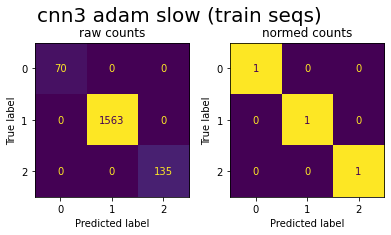

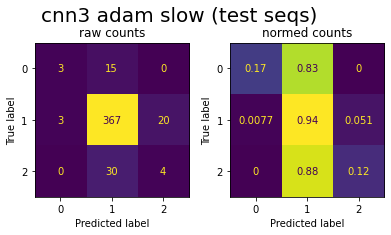

In [107]:
plot_confusion_raw_norm(
    model_res[cnn3_name]['model'],
    cnn3_name,
    train_df['upstream_region'].values,
    train_df['score_reg_UD'],
    "train seqs"
)

plot_confusion_raw_norm(
    model_res[cnn3_name]['model'],
    cnn3_name,
    test_df['upstream_region'].values,
    test_df['score_reg_UD'],
    "test seqs"
)

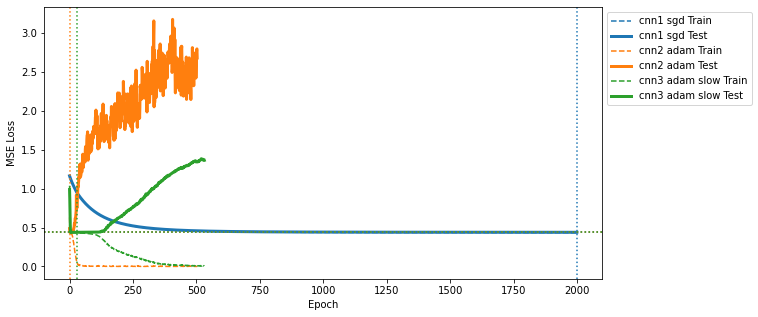

In [108]:
tu.quick_loss_plot([model_res[x]['data_label'][0] for x in model_res])

In [109]:
def augment_mutate(df,n,seq_col='upstream_region',mutation_rate=0.03):
    '''
    Given a dataframe of training data, augment it by adding 
    mutated versions back into the data frame
    '''
    mutation_dict = {
        'A':['C','G','T'],
        'C':['G','T','A'],
        'G':['T','A','C'],
        'T':['A','C','G']
    }
    new_rows = []
    # for each row in the original df
    for i,row in df.iterrows():
        seq = row[seq_col]
                
        # generate n mutants
        for j in range(n):
            new_row = copy.deepcopy(row)
            new_seq = list(seq)
            mutate_vec = [random.random() for x in range(len(seq))]
            
            # loop through mutation values along length of the seq
            for k in range(len(seq)):
                # if random value is below mutation rate, then make a change
                if mutate_vec[k] < mutation_rate:
                    cur_base = seq[k]
                    # select new base randomly
                    new_base = random.choice(mutation_dict[cur_base])
                    new_seq[k] = new_base
            
            new_row[seq_col] = ''.join(new_seq)
            new_row['seq_version'] = j+1
            new_rows.append(new_row.values)

    # put new rows into a df
    new_rows = pd.DataFrame(new_rows,columns=new_row.index)
    # add version to og df 
    df['seq_version'] = 0
    
    return pd.concat([df,new_rows])

In [110]:
aug_train_df = augment_mutate(train_df,10)
aug_train_df

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,...,CH4_500ppm,CH4_1000ppm,gene,product,type,score,score_reg_UD,highCu_reg_UD,set,seq_version
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,0.333441,-0.087509,-0.248330,-0.654293,0.0,0.252788,0.260753,...,0.668619,0.215153,dnaA,chromosomal replication initiator protein DnaA,CDS,-0.563333,1,1,train,0
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,0.179318,-0.183682,-0.493245,-1.323530,0.0,0.418315,0.611021,...,-0.462317,-0.490073,dnaN,DNA polymerase III subunit beta,CDS,-0.130000,1,2,train,0
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,0.364849,0.170159,-0.338861,-0.347147,0.0,0.287824,0.387577,...,0.144467,-0.239513,recF,DNA replication/repair protein RecF,CDS,-0.073333,1,1,train,0
3,4,EQU24_RS00035,GTATAAACCATGAAAGTCAGCCTATTTCGAAGATACCGACACCCTA...,0.193539,0.035923,0.136026,-0.642058,0.0,0.189394,0.345084,...,0.367039,0.695145,NaN,hypothetical protein,CDS,0.220000,1,1,train,0
4,9,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,0.173256,0.283822,-0.740565,-1.011908,0.0,0.215938,0.306791,...,-0.367242,-0.319915,NaN,bifunctional diguanylate cyclase/phosphodieste...,CDS,-0.146667,1,1,train,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17675,3540,EQU24_RS19410,TGGGCAAAAAACTTTCCGAGTTTGATTTCGACGGCGTGACGGTTTC...,1.183261,0.831256,-0.068947,-0.483096,0.0,0.548920,0.766772,...,-1.166172,-1.015641,tgt,tRNA guanosine(34) transglycosylase Tgt,CDS,-10.576667,0,2,train,6
17676,3540,EQU24_RS19410,TAGGCAAAAAACTTTCCGAGTTTGCTTTCGACGGCGTGAAGGTTTC...,1.183261,0.831256,-0.068947,-0.483096,0.0,0.548920,0.766772,...,-1.166172,-1.015641,tgt,tRNA guanosine(34) transglycosylase Tgt,CDS,-10.576667,0,2,train,7
17677,3540,EQU24_RS19410,TCGGCAAAAAGCTTTCCGAGTTTGCTTTCGACGGAGTGACGGTTTC...,1.183261,0.831256,-0.068947,-0.483096,0.0,0.548920,0.766772,...,-1.166172,-1.015641,tgt,tRNA guanosine(34) transglycosylase Tgt,CDS,-10.576667,0,2,train,8
17678,3540,EQU24_RS19410,TCGGCAAAAAACTTTCCGAGTTGGCTTTCGACGGCGTGACGGTTTC...,1.183261,0.831256,-0.068947,-0.483096,0.0,0.548920,0.766772,...,-1.166172,-1.015641,tgt,tRNA guanosine(34) transglycosylase Tgt,CDS,-10.576667,0,2,train,9


In [111]:
aug_dls = tu.build_dataloaders_single(
    aug_train_df, 
    test_df, 
    dataset_types,
    seq_col=seq_col_name,
    target_col=target_col_name,
)

aug_ohe_train_dl,aug_ohe_val_dl = aug_dls['ohe']

In [113]:
target_col_name

'score_reg_UD'

E:129 | train loss:0.081 | val loss: 1.646:   3%|▎         | 130/5000 [01:17<48:41,  1.67it/s]

EarlyStopping counter: 125 out of 500


E:254 | train loss:0.000 | val loss: 2.114:   5%|▌         | 255/5000 [02:33<47:55,  1.65it/s]

EarlyStopping counter: 250 out of 500


E:379 | train loss:0.000 | val loss: 2.327:   8%|▊         | 380/5000 [03:49<46:44,  1.65it/s]

EarlyStopping counter: 375 out of 500


E:504 | train loss:0.000 | val loss: 2.334:  10%|█         | 504/5000 [05:04<45:20,  1.65it/s]

EarlyStopping counter: 500 out of 500
Early stopping


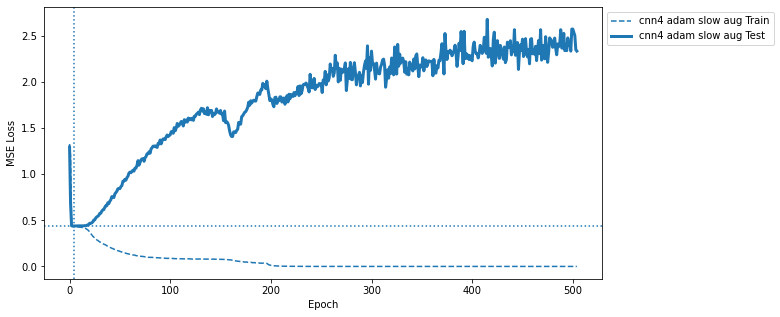

Running cnn4 adam slow aug
Running cnn4 adam slow aug


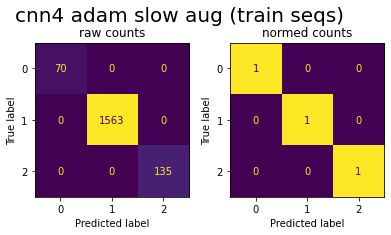

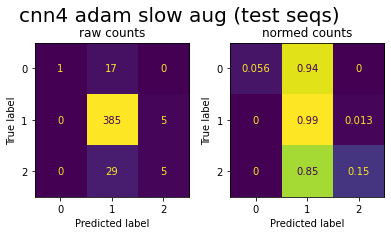

In [114]:
cnn4_name = 'cnn4 adam slow aug'
model_res[cnn4_name] = collect_model_stats(
    cnn4_name,
    seq_len,
    'ohe',
    aug_ohe_train_dl,
    aug_ohe_val_dl,
    lr=0.0001,
    ep=5000,
    pat=500,
    opt=torch.optim.Adam
)

plot_confusion_raw_norm(
    model_res[cnn4_name]['model'],
    cnn4_name,
    train_df['upstream_region'].values,
    train_df['score_reg_UD'],
    "train seqs"
)

plot_confusion_raw_norm(
    model_res[cnn4_name]['model'],
    cnn4_name,
    test_df['upstream_region'].values,
    test_df['score_reg_UD'],
    "test seqs"
)

In [38]:
target_col_name

'score'

E:127 | train loss:0.064 | val loss: 0.759:   3%|▎         | 128/5000 [01:31<57:45,  1.41it/s]

EarlyStopping counter: 125 out of 500


E:252 | train loss:0.028 | val loss: 1.000:   5%|▌         | 253/5000 [03:00<56:12,  1.41it/s]

EarlyStopping counter: 250 out of 500


E:377 | train loss:0.023 | val loss: 1.087:   8%|▊         | 378/5000 [04:29<55:02,  1.40it/s]

EarlyStopping counter: 375 out of 500


E:502 | train loss:0.017 | val loss: 1.128:  10%|█         | 502/5000 [05:58<53:34,  1.40it/s]

EarlyStopping counter: 500 out of 500
Early stopping


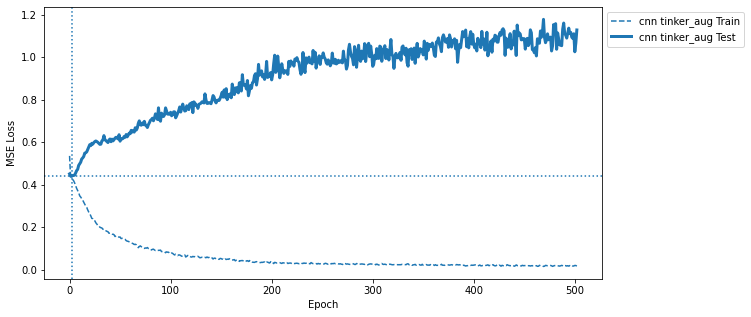

Running cnn tinker_aug
Running cnn tinker_aug


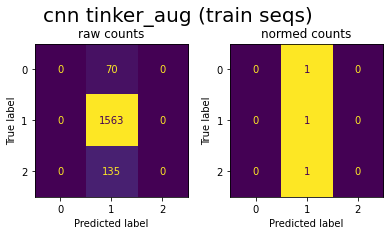

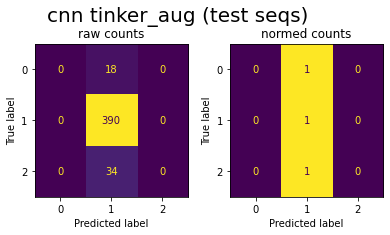

In [115]:
cnn_tinker = 'cnn tinker_aug'
model = m.DNA_2CNN_2FC_Multi(
    seq_len,
    3, # num tasks
    num_filters1=8,
    num_filters2=8,
    kernel_size1=6,
    kernel_size2=6,
    conv_pool_size1=2,
    fc_node_num1=10,
    fc_node_num2=10,
    dropout1=0.25
)

model_res[cnn_tinker] = collect_model_stats(
    cnn_tinker,
    seq_len,
    'ohe',
    aug_ohe_train_dl,
    aug_ohe_val_dl,
    lr=0.0005,
    ep=5000,
    pat=500,
    opt=torch.optim.Adam,
    model=model,
    load_best=True
)

plot_confusion_raw_norm(
    model_res[cnn_tinker]['model'],
    cnn_tinker,
    train_df['upstream_region'].values,
    train_df['score_reg_UD'],
    "train seqs"
)

plot_confusion_raw_norm(
    model_res[cnn_tinker]['model'],
    cnn_tinker,
    test_df['upstream_region'].values,
    test_df['score_reg_UD'],
    "test seqs"
)

In [118]:
cnn_tinker2 = 'cnn tinker2_aug'
model = m.DNA_2CNN_2FC_Multi(
    seq_len,
    3, # num tasks
    num_filters1=8,
    num_filters2=4,
    kernel_size1=10,
    kernel_size2=6,
    conv_pool_size1=2,
    fc_node_num1=5,
    fc_node_num2=5,
    dropout1=0.25
)

model_res[cnn_tinker2] = collect_model_stats(
    cnn_tinker2,
    seq_len,
    'ohe',
    aug_ohe_train_dl,
    aug_ohe_val_dl,
    lr=0.0005,
    ep=5000,
    pat=1000,
    opt=torch.optim.Adam,
    model=model,
    load_best=True
)

plot_confusion_raw_norm(
    model_res[cnn_tinker2]['model'],
    cnn_tinker2,
    train_df['upstream_region'].values,
    train_df['score_reg_UD'],
    "train seqs"
)

plot_confusion_raw_norm(
    model_res[cnn_tinker2]['model'],
    cnn_tinker2,
    test_df['upstream_region'].values,
    test_df['score_reg_UD'],
    "test seqs"
)

RuntimeError: CUDA error: device-side assert triggered

E:377 | train loss:6.326 | val loss: 10.881:   8%|▊         | 378/5000 [03:32<43:06,  1.79it/s] 

EarlyStopping counter: 250 out of 1000


E:1220 | train loss:3.495 | val loss: 7.738:  24%|██▍       | 1221/5000 [11:25<35:22,  1.78it/s]

EarlyStopping counter: 250 out of 1000


E:1720 | train loss:3.090 | val loss: 7.756:  34%|███▍      | 1721/5000 [16:06<30:39,  1.78it/s]

EarlyStopping counter: 750 out of 1000


E:1970 | train loss:3.077 | val loss: 7.796:  39%|███▉      | 1970/5000 [18:27<28:22,  1.78it/s]

EarlyStopping counter: 1000 out of 1000
Early stopping


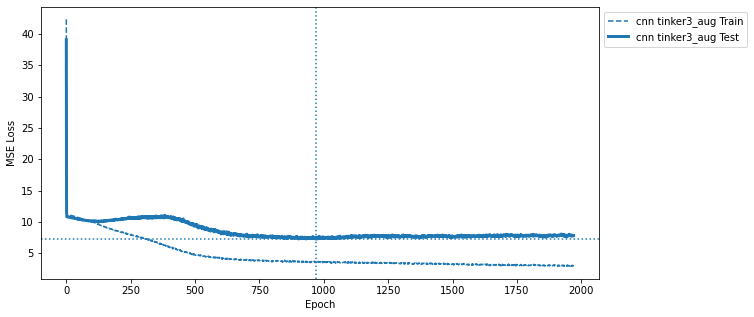

train split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

Running cnn tinker3_aug
val split
Running cnn tinker3_aug
test split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn tinker3_aug


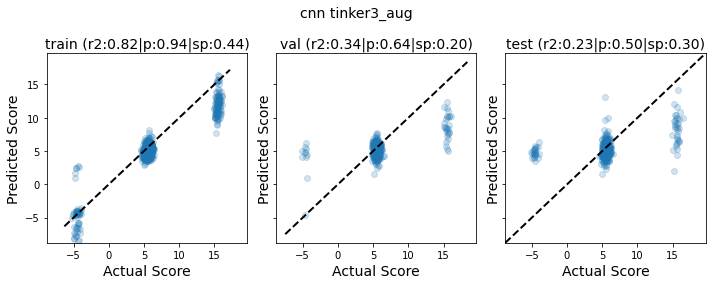

In [46]:
cnn_tinker3 = 'cnn tinker3_aug'
model = m.DNA_2CNN_2FC_Multi(
    seq_len,
    1, # num tasks
    num_filters1=8,
    num_filters2=4,
    kernel_size1=10,
    kernel_size2=6,
    conv_pool_size1=2,
    fc_node_num1=5,
    fc_node_num2=5,
    dropout1=0.25
)

model_res[cnn_tinker3] = collect_model_stats(
    cnn_tinker3,
    seq_len,
    'ohe',
    aug_ohe_train_dl,
    aug_ohe_val_dl,
    lr=0.0001,
    ep=5000,
    pat=1000,
    opt=torch.optim.Adam,
    model=model,
    load_best=True
)

pred_dfs[cnn_tinker3] = parity_pred_by_split(cnn_tinker3,
                     DEVICE,
                     split_dfs,
                     locus_col='locus_tag',
                     seq_col=seq_col_name,
                     target_col=target_col_name,
                     splits=['train','val','test']
                    )

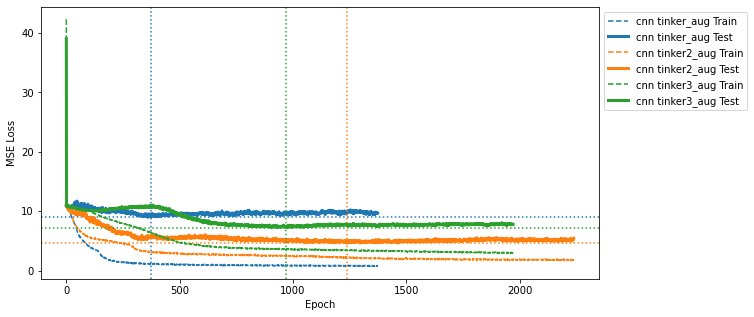

In [48]:
tu.quick_loss_plot([model_res[x]['data_label'][0] for x in [cnn_tinker,cnn_tinker2, cnn_tinker3]])